In [1]:
import torch
import numpy as np
import utils.render as my_render

device = torch.device('cuda:%d'%(0))

In [2]:
from utils.helper import to_np, to_tensor

In [3]:
verts = to_np([[-2, -2, -2], [0, 2, -2], [2, -2, -2], [2, 0, -1.5], [1, -1, -1.5]])
faces = to_np([[0, 1, 2], [2, 4, 3]])
print(verts.shape, faces.shape)

(5, 3) (2, 3)


In [4]:
verts = to_tensor(verts).to(device).unsqueeze(0)
faces = to_tensor(faces).to(device).unsqueeze(0)

In [147]:
from pytorch3d.io import load_obj

data = load_obj('bunny.obj')

verts = data[0]
faces = data[1].verts_idx
print(verts.shape, faces.shape)

torch.Size([2503, 3]) torch.Size([4968, 3])


In [148]:
verts = verts.to(device).unsqueeze(0)
faces = faces.to(device).unsqueeze(0)

In [149]:
texture_space = np.load('../FLAME/TextureSpace/FLAME_texture.npz')

In [150]:
verts_uv = texture_space['vt']
faces_uv = texture_space['ft']

verts_uv = to_tensor(to_np(verts_uv)).to(device).unsqueeze(0)
faces_uv = to_tensor(to_np(faces_uv)).to(device).unsqueeze(0)
uv_map = texture_space['mean']
uv_map = to_tensor(to_np(uv_map)).to(device).unsqueeze(0)

# verts_uv = to_tensor(to_np([[[0.9, 0],[0.9, 0],[0.9,0], [0, 0.9], [0, 0.9]]])).to(device)
# faces_uv = faces

print(verts_uv.shape, faces_uv.shape)

print(uv_map.shape)

torch.Size([1, 5118, 2]) torch.Size([1, 9976, 3])
torch.Size([1, 512, 512, 3])


In [151]:
# for i in range(512):
#     for j in range(512):
#         rate_x, rate_y = 1 - i/512, 1 - j / 512
#         #R通道
#         R1 = 255 * rate_x + 255 * (1-rate_x)
#         R2 = 0
#         v = R1 * rate_y + R2 * (1-rate_y)
#         uv_map[0, i, j, 0] = v
#         #G通道
#         R1 = 255 * rate_x + 0 * (1-rate_x)
#         R2 = 0 * rate_x + 255 * (1-rate_x)
#         v = R1 * rate_y + R2 * (1-rate_y)
#         uv_map[0, i, j, 1] = v
#         #B通道
#         R1 = 255 * rate_x + 0 * (1-rate_x)
#         R2 = 255 * rate_x + 0 * (1-rate_x)
#         v = R1 * rate_y + R2 * (1-rate_y)
#         uv_map[0, i, j, 2] = v
uv_map[..., 0]=255
uv_map[..., 1]=0
uv_map[..., 2]=0

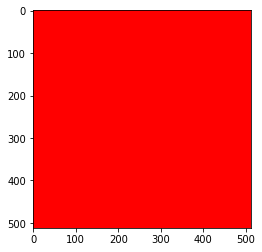

In [152]:
plt.imshow(uv_map.squeeze().cpu().numpy().astype(np.uint8))

In [153]:
uv_map = uv_map.permute(0, 3, 1, 2)

image_size=256
num_faces_per_pixel = 1
lighting_params = (torch.ones([1, 9]).to(device)*255.)
lighting_type = 'directional'
z_near = 1
z_far = 2
fovY = 120
aspect_ratio = 1

In [154]:
lighting_params[:, 0] = 0.7
lighting_params[:, 1] = 0.7
lighting_params[:, 2] = 0.7
lighting_params[:, 3] = 0.1
lighting_params[:, 4] = 0.1
lighting_params[:, 5] = 0.1
lighting_params[:, 6] = 0
lighting_params[:, 7] = 0
lighting_params[:, 8] = 1

In [155]:
verts = verts * 25
verts[..., -1] -= 3
verts[..., 1] -= 3
print(verts[..., -1].max(), verts[..., -1].min())
print(verts[..., 0].max(), verts[..., 0].min())
print(verts[..., 1].max(), verts[..., 1].min())

tensor(-1.5321, device='cuda:0') tensor(-4.5420, device='cuda:0')
tensor(1.5195, device='cuda:0') tensor(-2.3595, device='cuda:0')
tensor(1.6749, device='cuda:0') tensor(-2.1673, device='cuda:0')


In [156]:
import imp
imp.reload(my_render)

test_model = my_render.Render(device=device).to(device)
output = test_model(
        verts,#(B, V, 3) 
        faces,#(B, F, 3)
        verts_uv,#(B, V, 2)
        faces_uv,#(B, F, 3)
        image_size,
        num_faces_per_pixel,
        uv_map, #(B, 3, H, W)
        lighting_params,
        lighting_type,
        #camera的参数也太多了，这部分要参考其他的fitting代码
        z_near,
        z_far,
        fovY,
        aspect_ratio,
        lighting_direction=None,
        camera_location=((0, 0, 0),),
        camera_direction=((0,0,-1),),
        camera_up=((0,1,0),),)

100%|██████████| 4968/4968 [01:19<00:00, 62.13it/s] 

torch.Size([1, 256, 256, 1, 3])


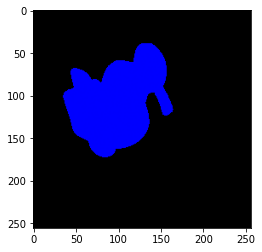

In [168]:
from matplotlib import pyplot as plt
plt.imshow((output[3]).squeeze().permute(1,2,0).detach().cpu().numpy().astype(np.uint8))

In [169]:
import cv2 as cv
cv.imwrite('bunny.png', (output[3]).squeeze().permute(1,2,0).detach().cpu().numpy().astype(np.uint8)[..., [2, 1, 0]])

True

In [25]:
uv_map[0, :, 0, 0]

tensor([0.5197, 0.0331, 1.2757], device='cuda:0')

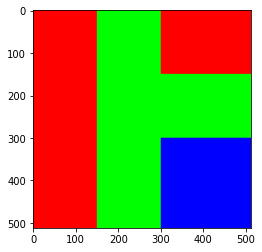

In [33]:
uv_map[:, :150, :150, 0] = 255
uv_map[:, :150, :150, 1] = 0
uv_map[:, :150, :150, 2] = 0

uv_map[:, :150, :150, 0] = 255
uv_map[:, :150, :150, 1] = 0
uv_map[:, :150, :150, 2] = 0

uv_map[:, 150:300, 150:300, 0] = 0
uv_map[:, 150:300, 150:300, 1] = 255
uv_map[:, 150:300, 150:300, 2] = 0

uv_map[:, 150:300, 150:300, 0] = 0
uv_map[:, 150:300, 150:300, 1] = 255
uv_map[:, 150:300, 150:300, 2] = 0

uv_map[:, 300:, 300:, 0] = 0
uv_map[:, 300:, 300:, 1] = 0
uv_map[:, 300:, 300:, 2] = 255

# uv_map[:, :, 150:300, 0] = 0
# uv_map[:, :, 150:300, 1] = 255
# uv_map[:, :, 150:300, 2] = 0


plt.imshow(uv_map.squeeze().cpu().numpy().astype(np.uint8))

In [32]:
faces_uv_coord = output[4]

faces_uv_coord.shape

torch.Size([1, 256, 256, 2])

In [33]:
faces_uv_coord = faces_uv_coord.squeeze()

In [23]:
for i in range(256):
    for j in range(256):
        if faces_uv_coord[i, j, 0]!=0 and faces_uv_coord[i, j, 1]!=0:
            print(i, j, faces_uv_coord[i, j])

30 30 tensor([0.1022, 0.1022], device='cuda:0')
31 30 tensor([0.1062, 0.1062], device='cuda:0')
31 31 tensor([0.1062, 0.1062], device='cuda:0')
31 32 tensor([0.1062, 0.1062], device='cuda:0')
32 30 tensor([0.1103, 0.1103], device='cuda:0')
32 31 tensor([0.1103, 0.1103], device='cuda:0')
32 32 tensor([0.1103, 0.1103], device='cuda:0')
32 33 tensor([0.1103, 0.1103], device='cuda:0')
32 34 tensor([0.1103, 0.1103], device='cuda:0')
33 30 tensor([0.1143, 0.1143], device='cuda:0')
33 31 tensor([0.1143, 0.1143], device='cuda:0')
33 32 tensor([0.1143, 0.1143], device='cuda:0')
33 33 tensor([0.1143, 0.1143], device='cuda:0')
33 34 tensor([0.1143, 0.1143], device='cuda:0')
33 35 tensor([0.1143, 0.1143], device='cuda:0')
33 36 tensor([0.1143, 0.1143], device='cuda:0')
34 30 tensor([0.1184, 0.1184], device='cuda:0')
34 31 tensor([0.1184, 0.1184], device='cuda:0')
34 32 tensor([0.1184, 0.1184], device='cuda:0')
34 33 tensor([0.1184, 0.1184], device='cuda:0')
34 34 tensor([0.1184, 0.1184], device='c

43 40 tensor([0.1549, 0.1549], device='cuda:0')
43 41 tensor([0.1549, 0.1549], device='cuda:0')
43 42 tensor([0.1549, 0.1549], device='cuda:0')
43 43 tensor([0.1549, 0.1549], device='cuda:0')
43 44 tensor([0.1549, 0.1549], device='cuda:0')
43 45 tensor([0.1549, 0.1549], device='cuda:0')
43 46 tensor([0.1549, 0.1549], device='cuda:0')
43 47 tensor([0.1549, 0.1549], device='cuda:0')
43 48 tensor([0.1549, 0.1549], device='cuda:0')
43 49 tensor([0.1549, 0.1549], device='cuda:0')
43 50 tensor([0.1549, 0.1549], device='cuda:0')
43 51 tensor([0.1549, 0.1549], device='cuda:0')
43 52 tensor([0.1549, 0.1549], device='cuda:0')
43 53 tensor([0.1549, 0.1549], device='cuda:0')
43 54 tensor([0.1549, 0.1549], device='cuda:0')
43 55 tensor([0.1549, 0.1549], device='cuda:0')
43 56 tensor([0.1549, 0.1549], device='cuda:0')
44 30 tensor([0.1590, 0.1590], device='cuda:0')
44 31 tensor([0.1590, 0.1590], device='cuda:0')
44 32 tensor([0.1590, 0.1590], device='cuda:0')
44 33 tensor([0.1590, 0.1590], device='c

50 53 tensor([0.1834, 0.1834], device='cuda:0')
50 54 tensor([0.1834, 0.1834], device='cuda:0')
50 55 tensor([0.1834, 0.1834], device='cuda:0')
50 56 tensor([0.1834, 0.1834], device='cuda:0')
50 57 tensor([0.1834, 0.1834], device='cuda:0')
50 58 tensor([0.1834, 0.1834], device='cuda:0')
50 59 tensor([0.1834, 0.1834], device='cuda:0')
50 60 tensor([0.1834, 0.1834], device='cuda:0')
50 61 tensor([0.1834, 0.1834], device='cuda:0')
50 62 tensor([0.1834, 0.1834], device='cuda:0')
50 63 tensor([0.1834, 0.1834], device='cuda:0')
50 64 tensor([0.1834, 0.1834], device='cuda:0')
50 65 tensor([0.1834, 0.1834], device='cuda:0')
50 66 tensor([0.1834, 0.1834], device='cuda:0')
50 67 tensor([0.1834, 0.1834], device='cuda:0')
50 68 tensor([0.1834, 0.1834], device='cuda:0')
50 69 tensor([0.1834, 0.1834], device='cuda:0')
50 70 tensor([0.1834, 0.1834], device='cuda:0')
51 30 tensor([0.1874, 0.1874], device='cuda:0')
51 31 tensor([0.1874, 0.1874], device='cuda:0')
51 32 tensor([0.1874, 0.1874], device='c

56 33 tensor([0.2077, 0.2077], device='cuda:0')
56 34 tensor([0.2077, 0.2077], device='cuda:0')
56 35 tensor([0.2077, 0.2077], device='cuda:0')
56 36 tensor([0.2077, 0.2077], device='cuda:0')
56 37 tensor([0.2077, 0.2077], device='cuda:0')
56 38 tensor([0.2077, 0.2077], device='cuda:0')
56 39 tensor([0.2077, 0.2077], device='cuda:0')
56 40 tensor([0.2077, 0.2077], device='cuda:0')
56 41 tensor([0.2077, 0.2077], device='cuda:0')
56 42 tensor([0.2077, 0.2077], device='cuda:0')
56 43 tensor([0.2077, 0.2077], device='cuda:0')
56 44 tensor([0.2077, 0.2077], device='cuda:0')
56 45 tensor([0.2077, 0.2077], device='cuda:0')
56 46 tensor([0.2077, 0.2077], device='cuda:0')
56 47 tensor([0.2077, 0.2077], device='cuda:0')
56 48 tensor([0.2077, 0.2077], device='cuda:0')
56 49 tensor([0.2077, 0.2077], device='cuda:0')
56 50 tensor([0.2077, 0.2077], device='cuda:0')
56 51 tensor([0.2077, 0.2077], device='cuda:0')
56 52 tensor([0.2077, 0.2077], device='cuda:0')
56 53 tensor([0.2077, 0.2077], device='c

60 84 tensor([0.2240, 0.2240], device='cuda:0')
60 85 tensor([0.2240, 0.2240], device='cuda:0')
60 86 tensor([0.2240, 0.2240], device='cuda:0')
60 87 tensor([0.2240, 0.2240], device='cuda:0')
60 88 tensor([0.2240, 0.2240], device='cuda:0')
60 89 tensor([0.2240, 0.2240], device='cuda:0')
60 90 tensor([0.2240, 0.2240], device='cuda:0')
61 30 tensor([0.2280, 0.2280], device='cuda:0')
61 31 tensor([0.2280, 0.2280], device='cuda:0')
61 32 tensor([0.2280, 0.2280], device='cuda:0')
61 33 tensor([0.2280, 0.2280], device='cuda:0')
61 34 tensor([0.2280, 0.2280], device='cuda:0')
61 35 tensor([0.2280, 0.2280], device='cuda:0')
61 36 tensor([0.2280, 0.2280], device='cuda:0')
61 37 tensor([0.2280, 0.2280], device='cuda:0')
61 38 tensor([0.2280, 0.2280], device='cuda:0')
61 39 tensor([0.2280, 0.2280], device='cuda:0')
61 40 tensor([0.2280, 0.2280], device='cuda:0')
61 41 tensor([0.2280, 0.2280], device='cuda:0')
61 42 tensor([0.2280, 0.2280], device='cuda:0')
61 43 tensor([0.2280, 0.2280], device='c

65 31 tensor([0.2443, 0.2443], device='cuda:0')
65 32 tensor([0.2443, 0.2443], device='cuda:0')
65 33 tensor([0.2443, 0.2443], device='cuda:0')
65 34 tensor([0.2443, 0.2443], device='cuda:0')
65 35 tensor([0.2443, 0.2443], device='cuda:0')
65 36 tensor([0.2443, 0.2443], device='cuda:0')
65 37 tensor([0.2443, 0.2443], device='cuda:0')
65 38 tensor([0.2443, 0.2443], device='cuda:0')
65 39 tensor([0.2443, 0.2443], device='cuda:0')
65 40 tensor([0.2443, 0.2443], device='cuda:0')
65 41 tensor([0.2443, 0.2443], device='cuda:0')
65 42 tensor([0.2443, 0.2443], device='cuda:0')
65 43 tensor([0.2443, 0.2443], device='cuda:0')
65 44 tensor([0.2443, 0.2443], device='cuda:0')
65 45 tensor([0.2443, 0.2443], device='cuda:0')
65 46 tensor([0.2443, 0.2443], device='cuda:0')
65 47 tensor([0.2443, 0.2443], device='cuda:0')
65 48 tensor([0.2443, 0.2443], device='cuda:0')
65 49 tensor([0.2443, 0.2443], device='cuda:0')
65 50 tensor([0.2443, 0.2443], device='cuda:0')
65 51 tensor([0.2443, 0.2443], device='c

68 100 tensor([0.2564, 0.2564], device='cuda:0')
68 101 tensor([0.2564, 0.2564], device='cuda:0')
68 102 tensor([0.2564, 0.2564], device='cuda:0')
68 103 tensor([0.2564, 0.2564], device='cuda:0')
68 104 tensor([0.2564, 0.2564], device='cuda:0')
68 105 tensor([0.2564, 0.2564], device='cuda:0')
68 106 tensor([0.2564, 0.2564], device='cuda:0')
69 30 tensor([0.2605, 0.2605], device='cuda:0')
69 31 tensor([0.2605, 0.2605], device='cuda:0')
69 32 tensor([0.2605, 0.2605], device='cuda:0')
69 33 tensor([0.2605, 0.2605], device='cuda:0')
69 34 tensor([0.2605, 0.2605], device='cuda:0')
69 35 tensor([0.2605, 0.2605], device='cuda:0')
69 36 tensor([0.2605, 0.2605], device='cuda:0')
69 37 tensor([0.2605, 0.2605], device='cuda:0')
69 38 tensor([0.2605, 0.2605], device='cuda:0')
69 39 tensor([0.2605, 0.2605], device='cuda:0')
69 40 tensor([0.2605, 0.2605], device='cuda:0')
69 41 tensor([0.2605, 0.2605], device='cuda:0')
69 42 tensor([0.2605, 0.2605], device='cuda:0')
69 43 tensor([0.2605, 0.2605], de

72 58 tensor([0.2727, 0.2727], device='cuda:0')
72 59 tensor([0.2727, 0.2727], device='cuda:0')
72 60 tensor([0.2727, 0.2727], device='cuda:0')
72 61 tensor([0.2727, 0.2727], device='cuda:0')
72 62 tensor([0.2727, 0.2727], device='cuda:0')
72 63 tensor([0.2727, 0.2727], device='cuda:0')
72 64 tensor([0.2727, 0.2727], device='cuda:0')
72 65 tensor([0.2727, 0.2727], device='cuda:0')
72 66 tensor([0.2727, 0.2727], device='cuda:0')
72 67 tensor([0.2727, 0.2727], device='cuda:0')
72 68 tensor([0.2727, 0.2727], device='cuda:0')
72 69 tensor([0.2727, 0.2727], device='cuda:0')
72 70 tensor([0.2727, 0.2727], device='cuda:0')
72 71 tensor([0.2727, 0.2727], device='cuda:0')
72 72 tensor([0.2727, 0.2727], device='cuda:0')
72 73 tensor([0.2727, 0.2727], device='cuda:0')
72 74 tensor([0.2727, 0.2727], device='cuda:0')
72 75 tensor([0.2727, 0.2727], device='cuda:0')
72 76 tensor([0.2727, 0.2727], device='cuda:0')
72 77 tensor([0.2727, 0.2727], device='cuda:0')
72 78 tensor([0.2727, 0.2727], device='c

75 89 tensor([0.2848, 0.2848], device='cuda:0')
75 90 tensor([0.2848, 0.2848], device='cuda:0')
75 91 tensor([0.2848, 0.2848], device='cuda:0')
75 92 tensor([0.2848, 0.2848], device='cuda:0')
75 93 tensor([0.2848, 0.2848], device='cuda:0')
75 94 tensor([0.2848, 0.2848], device='cuda:0')
75 95 tensor([0.2848, 0.2848], device='cuda:0')
75 96 tensor([0.2848, 0.2848], device='cuda:0')
75 97 tensor([0.2848, 0.2848], device='cuda:0')
75 98 tensor([0.2848, 0.2848], device='cuda:0')
75 99 tensor([0.2848, 0.2848], device='cuda:0')
75 100 tensor([0.2848, 0.2848], device='cuda:0')
75 101 tensor([0.2848, 0.2848], device='cuda:0')
75 102 tensor([0.2848, 0.2848], device='cuda:0')
75 103 tensor([0.2848, 0.2848], device='cuda:0')
75 104 tensor([0.2848, 0.2848], device='cuda:0')
75 105 tensor([0.2848, 0.2848], device='cuda:0')
75 106 tensor([0.2848, 0.2848], device='cuda:0')
75 107 tensor([0.2848, 0.2848], device='cuda:0')
75 108 tensor([0.2848, 0.2848], device='cuda:0')
75 109 tensor([0.2848, 0.2848],

78 105 tensor([0.2970, 0.2970], device='cuda:0')
78 106 tensor([0.2970, 0.2970], device='cuda:0')
78 107 tensor([0.2970, 0.2970], device='cuda:0')
78 108 tensor([0.2970, 0.2970], device='cuda:0')
78 109 tensor([0.2970, 0.2970], device='cuda:0')
78 110 tensor([0.2970, 0.2970], device='cuda:0')
78 111 tensor([0.2970, 0.2970], device='cuda:0')
78 112 tensor([0.2970, 0.2970], device='cuda:0')
78 113 tensor([0.2970, 0.2970], device='cuda:0')
78 114 tensor([0.2970, 0.2970], device='cuda:0')
78 115 tensor([0.2970, 0.2970], device='cuda:0')
78 116 tensor([0.2970, 0.2970], device='cuda:0')
78 117 tensor([0.2970, 0.2970], device='cuda:0')
78 118 tensor([0.2970, 0.2970], device='cuda:0')
78 119 tensor([0.2970, 0.2970], device='cuda:0')
78 120 tensor([0.2970, 0.2970], device='cuda:0')
78 121 tensor([0.2970, 0.2970], device='cuda:0')
78 122 tensor([0.2970, 0.2970], device='cuda:0')
78 123 tensor([0.2970, 0.2970], device='cuda:0')
78 124 tensor([0.2970, 0.2970], device='cuda:0')
78 125 tensor([0.297

81 103 tensor([0.3092, 0.3092], device='cuda:0')
81 104 tensor([0.3092, 0.3092], device='cuda:0')
81 105 tensor([0.3092, 0.3092], device='cuda:0')
81 106 tensor([0.3092, 0.3092], device='cuda:0')
81 107 tensor([0.3092, 0.3092], device='cuda:0')
81 108 tensor([0.3092, 0.3092], device='cuda:0')
81 109 tensor([0.3092, 0.3092], device='cuda:0')
81 110 tensor([0.3092, 0.3092], device='cuda:0')
81 111 tensor([0.3092, 0.3092], device='cuda:0')
81 112 tensor([0.3092, 0.3092], device='cuda:0')
81 113 tensor([0.3092, 0.3092], device='cuda:0')
81 114 tensor([0.3092, 0.3092], device='cuda:0')
81 115 tensor([0.3092, 0.3092], device='cuda:0')
81 116 tensor([0.3092, 0.3092], device='cuda:0')
81 117 tensor([0.3092, 0.3092], device='cuda:0')
81 118 tensor([0.3092, 0.3092], device='cuda:0')
81 119 tensor([0.3092, 0.3092], device='cuda:0')
81 120 tensor([0.3092, 0.3092], device='cuda:0')
81 121 tensor([0.3092, 0.3092], device='cuda:0')
81 122 tensor([0.3092, 0.3092], device='cuda:0')
81 123 tensor([0.309

84 77 tensor([0.3214, 0.3214], device='cuda:0')
84 78 tensor([0.3214, 0.3214], device='cuda:0')
84 79 tensor([0.3214, 0.3214], device='cuda:0')
84 80 tensor([0.3214, 0.3214], device='cuda:0')
84 81 tensor([0.3214, 0.3214], device='cuda:0')
84 82 tensor([0.3214, 0.3214], device='cuda:0')
84 83 tensor([0.3214, 0.3214], device='cuda:0')
84 84 tensor([0.3214, 0.3214], device='cuda:0')
84 85 tensor([0.3214, 0.3214], device='cuda:0')
84 86 tensor([0.3214, 0.3214], device='cuda:0')
84 87 tensor([0.3214, 0.3214], device='cuda:0')
84 88 tensor([0.3214, 0.3214], device='cuda:0')
84 89 tensor([0.3214, 0.3214], device='cuda:0')
84 90 tensor([0.3214, 0.3214], device='cuda:0')
84 91 tensor([0.3214, 0.3214], device='cuda:0')
84 92 tensor([0.3214, 0.3214], device='cuda:0')
84 93 tensor([0.3214, 0.3214], device='cuda:0')
84 94 tensor([0.3214, 0.3214], device='cuda:0')
84 95 tensor([0.3214, 0.3214], device='cuda:0')
84 96 tensor([0.3214, 0.3214], device='cuda:0')
84 97 tensor([0.3214, 0.3214], device='c

87 36 tensor([0.3336, 0.3336], device='cuda:0')
87 37 tensor([0.3336, 0.3336], device='cuda:0')
87 38 tensor([0.3336, 0.3336], device='cuda:0')
87 39 tensor([0.3336, 0.3336], device='cuda:0')
87 40 tensor([0.3336, 0.3336], device='cuda:0')
87 41 tensor([0.3336, 0.3336], device='cuda:0')
87 42 tensor([0.3336, 0.3336], device='cuda:0')
87 43 tensor([0.3336, 0.3336], device='cuda:0')
87 44 tensor([0.3336, 0.3336], device='cuda:0')
87 45 tensor([0.3336, 0.3336], device='cuda:0')
87 46 tensor([0.3336, 0.3336], device='cuda:0')
87 47 tensor([0.3336, 0.3336], device='cuda:0')
87 48 tensor([0.3336, 0.3336], device='cuda:0')
87 49 tensor([0.3336, 0.3336], device='cuda:0')
87 50 tensor([0.3336, 0.3336], device='cuda:0')
87 51 tensor([0.3336, 0.3336], device='cuda:0')
87 52 tensor([0.3336, 0.3336], device='cuda:0')
87 53 tensor([0.3336, 0.3336], device='cuda:0')
87 54 tensor([0.3336, 0.3336], device='cuda:0')
87 55 tensor([0.3336, 0.3336], device='cuda:0')
87 56 tensor([0.3336, 0.3336], device='c

89 102 tensor([0.3417, 0.3417], device='cuda:0')
89 103 tensor([0.3417, 0.3417], device='cuda:0')
89 104 tensor([0.3417, 0.3417], device='cuda:0')
89 105 tensor([0.3417, 0.3417], device='cuda:0')
89 106 tensor([0.3417, 0.3417], device='cuda:0')
89 107 tensor([0.3417, 0.3417], device='cuda:0')
89 108 tensor([0.3417, 0.3417], device='cuda:0')
89 109 tensor([0.3417, 0.3417], device='cuda:0')
89 110 tensor([0.3417, 0.3417], device='cuda:0')
89 111 tensor([0.3417, 0.3417], device='cuda:0')
89 112 tensor([0.3417, 0.3417], device='cuda:0')
89 113 tensor([0.3417, 0.3417], device='cuda:0')
89 114 tensor([0.3417, 0.3417], device='cuda:0')
89 115 tensor([0.3417, 0.3417], device='cuda:0')
89 116 tensor([0.3417, 0.3417], device='cuda:0')
89 117 tensor([0.3417, 0.3417], device='cuda:0')
89 118 tensor([0.3417, 0.3417], device='cuda:0')
89 119 tensor([0.3417, 0.3417], device='cuda:0')
89 120 tensor([0.3417, 0.3417], device='cuda:0')
89 121 tensor([0.3417, 0.3417], device='cuda:0')
89 122 tensor([0.341

91 147 tensor([0.3498, 0.3498], device='cuda:0')
91 148 tensor([0.3498, 0.3498], device='cuda:0')
91 149 tensor([0.3498, 0.3498], device='cuda:0')
91 150 tensor([0.3498, 0.3498], device='cuda:0')
91 151 tensor([0.3498, 0.3498], device='cuda:0')
91 152 tensor([0.3498, 0.3498], device='cuda:0')
92 30 tensor([0.3539, 0.3539], device='cuda:0')
92 31 tensor([0.3539, 0.3539], device='cuda:0')
92 32 tensor([0.3539, 0.3539], device='cuda:0')
92 33 tensor([0.3539, 0.3539], device='cuda:0')
92 34 tensor([0.3539, 0.3539], device='cuda:0')
92 35 tensor([0.3539, 0.3539], device='cuda:0')
92 36 tensor([0.3539, 0.3539], device='cuda:0')
92 37 tensor([0.3539, 0.3539], device='cuda:0')
92 38 tensor([0.3539, 0.3539], device='cuda:0')
92 39 tensor([0.3539, 0.3539], device='cuda:0')
92 40 tensor([0.3539, 0.3539], device='cuda:0')
92 41 tensor([0.3539, 0.3539], device='cuda:0')
92 42 tensor([0.3539, 0.3539], device='cuda:0')
92 43 tensor([0.3539, 0.3539], device='cuda:0')
92 44 tensor([0.3539, 0.3539], dev

94 56 tensor([0.3620, 0.3620], device='cuda:0')
94 57 tensor([0.3620, 0.3620], device='cuda:0')
94 58 tensor([0.3620, 0.3620], device='cuda:0')
94 59 tensor([0.3620, 0.3620], device='cuda:0')
94 60 tensor([0.3620, 0.3620], device='cuda:0')
94 61 tensor([0.3620, 0.3620], device='cuda:0')
94 62 tensor([0.3620, 0.3620], device='cuda:0')
94 63 tensor([0.3620, 0.3620], device='cuda:0')
94 64 tensor([0.3620, 0.3620], device='cuda:0')
94 65 tensor([0.3620, 0.3620], device='cuda:0')
94 66 tensor([0.3620, 0.3620], device='cuda:0')
94 67 tensor([0.3620, 0.3620], device='cuda:0')
94 68 tensor([0.3620, 0.3620], device='cuda:0')
94 69 tensor([0.3620, 0.3620], device='cuda:0')
94 70 tensor([0.3620, 0.3620], device='cuda:0')
94 71 tensor([0.3620, 0.3620], device='cuda:0')
94 72 tensor([0.3620, 0.3620], device='cuda:0')
94 73 tensor([0.3620, 0.3620], device='cuda:0')
94 74 tensor([0.3620, 0.3620], device='cuda:0')
94 75 tensor([0.3620, 0.3620], device='cuda:0')
94 76 tensor([0.3620, 0.3620], device='c

96 97 tensor([0.3701, 0.3701], device='cuda:0')
96 98 tensor([0.3701, 0.3701], device='cuda:0')
96 99 tensor([0.3701, 0.3701], device='cuda:0')
96 100 tensor([0.3701, 0.3701], device='cuda:0')
96 101 tensor([0.3701, 0.3701], device='cuda:0')
96 102 tensor([0.3701, 0.3701], device='cuda:0')
96 103 tensor([0.3701, 0.3701], device='cuda:0')
96 104 tensor([0.3701, 0.3701], device='cuda:0')
96 105 tensor([0.3701, 0.3701], device='cuda:0')
96 106 tensor([0.3701, 0.3701], device='cuda:0')
96 107 tensor([0.3701, 0.3701], device='cuda:0')
96 108 tensor([0.3701, 0.3701], device='cuda:0')
96 109 tensor([0.3701, 0.3701], device='cuda:0')
96 110 tensor([0.3701, 0.3701], device='cuda:0')
96 111 tensor([0.3701, 0.3701], device='cuda:0')
96 112 tensor([0.3701, 0.3701], device='cuda:0')
96 113 tensor([0.3701, 0.3701], device='cuda:0')
96 114 tensor([0.3701, 0.3701], device='cuda:0')
96 115 tensor([0.3701, 0.3701], device='cuda:0')
96 116 tensor([0.3701, 0.3701], device='cuda:0')
96 117 tensor([0.3701, 

98 129 tensor([0.3782, 0.3782], device='cuda:0')
98 130 tensor([0.3782, 0.3782], device='cuda:0')
98 131 tensor([0.3782, 0.3782], device='cuda:0')
98 132 tensor([0.3782, 0.3782], device='cuda:0')
98 133 tensor([0.3782, 0.3782], device='cuda:0')
98 134 tensor([0.3782, 0.3782], device='cuda:0')
98 135 tensor([0.3782, 0.3782], device='cuda:0')
98 136 tensor([0.3782, 0.3782], device='cuda:0')
98 137 tensor([0.3782, 0.3782], device='cuda:0')
98 138 tensor([0.3782, 0.3782], device='cuda:0')
98 139 tensor([0.3782, 0.3782], device='cuda:0')
98 140 tensor([0.3782, 0.3782], device='cuda:0')
98 141 tensor([0.3782, 0.3782], device='cuda:0')
98 142 tensor([0.3782, 0.3782], device='cuda:0')
98 143 tensor([0.3782, 0.3782], device='cuda:0')
98 144 tensor([0.3782, 0.3782], device='cuda:0')
98 145 tensor([0.3782, 0.3782], device='cuda:0')
98 146 tensor([0.3782, 0.3782], device='cuda:0')
98 147 tensor([0.3782, 0.3782], device='cuda:0')
98 148 tensor([0.3782, 0.3782], device='cuda:0')
98 149 tensor([0.378

100 153 tensor([0.3863, 0.3863], device='cuda:0')
100 154 tensor([0.3863, 0.3863], device='cuda:0')
100 155 tensor([0.3863, 0.3863], device='cuda:0')
100 156 tensor([0.3863, 0.3863], device='cuda:0')
100 157 tensor([0.3863, 0.3863], device='cuda:0')
100 158 tensor([0.3863, 0.3863], device='cuda:0')
100 159 tensor([0.3863, 0.3863], device='cuda:0')
100 160 tensor([0.3863, 0.3863], device='cuda:0')
100 161 tensor([0.3863, 0.3863], device='cuda:0')
100 162 tensor([0.3863, 0.3863], device='cuda:0')
100 163 tensor([0.3863, 0.3863], device='cuda:0')
100 164 tensor([0.3863, 0.3863], device='cuda:0')
100 165 tensor([0.3863, 0.3863], device='cuda:0')
100 166 tensor([0.3863, 0.3863], device='cuda:0')
100 167 tensor([0.3863, 0.3863], device='cuda:0')
100 168 tensor([0.3863, 0.3863], device='cuda:0')
100 169 tensor([0.3863, 0.3863], device='cuda:0')
100 170 tensor([0.3863, 0.3863], device='cuda:0')
101 30 tensor([0.3904, 0.3904], device='cuda:0')
101 31 tensor([0.3904, 0.3904], device='cuda:0')
10

102 170 tensor([0.3945, 0.3945], device='cuda:0')
102 171 tensor([0.3945, 0.3945], device='cuda:0')
102 172 tensor([0.3945, 0.3945], device='cuda:0')
102 173 tensor([0.3945, 0.3945], device='cuda:0')
102 174 tensor([0.3945, 0.3945], device='cuda:0')
103 30 tensor([0.3985, 0.3985], device='cuda:0')
103 31 tensor([0.3985, 0.3985], device='cuda:0')
103 32 tensor([0.3985, 0.3985], device='cuda:0')
103 33 tensor([0.3985, 0.3985], device='cuda:0')
103 34 tensor([0.3985, 0.3985], device='cuda:0')
103 35 tensor([0.3985, 0.3985], device='cuda:0')
103 36 tensor([0.3985, 0.3985], device='cuda:0')
103 37 tensor([0.3985, 0.3985], device='cuda:0')
103 38 tensor([0.3985, 0.3985], device='cuda:0')
103 39 tensor([0.3985, 0.3985], device='cuda:0')
103 40 tensor([0.3985, 0.3985], device='cuda:0')
103 41 tensor([0.3985, 0.3985], device='cuda:0')
103 42 tensor([0.3985, 0.3985], device='cuda:0')
103 43 tensor([0.3985, 0.3985], device='cuda:0')
103 44 tensor([0.3985, 0.3985], device='cuda:0')
103 45 tensor([

105 30 tensor([0.4066, 0.4066], device='cuda:0')
105 31 tensor([0.4066, 0.4066], device='cuda:0')
105 32 tensor([0.4066, 0.4066], device='cuda:0')
105 33 tensor([0.4066, 0.4066], device='cuda:0')
105 34 tensor([0.4066, 0.4066], device='cuda:0')
105 35 tensor([0.4066, 0.4066], device='cuda:0')
105 36 tensor([0.4066, 0.4066], device='cuda:0')
105 37 tensor([0.4066, 0.4066], device='cuda:0')
105 38 tensor([0.4066, 0.4066], device='cuda:0')
105 39 tensor([0.4066, 0.4066], device='cuda:0')
105 40 tensor([0.4066, 0.4066], device='cuda:0')
105 41 tensor([0.4066, 0.4066], device='cuda:0')
105 42 tensor([0.4066, 0.4066], device='cuda:0')
105 43 tensor([0.4066, 0.4066], device='cuda:0')
105 44 tensor([0.4066, 0.4066], device='cuda:0')
105 45 tensor([0.4066, 0.4066], device='cuda:0')
105 46 tensor([0.4066, 0.4066], device='cuda:0')
105 47 tensor([0.4066, 0.4066], device='cuda:0')
105 48 tensor([0.4066, 0.4066], device='cuda:0')
105 49 tensor([0.4066, 0.4066], device='cuda:0')
105 50 tensor([0.406

107 30 tensor([0.4148, 0.4148], device='cuda:0')
107 31 tensor([0.4148, 0.4148], device='cuda:0')
107 32 tensor([0.4148, 0.4148], device='cuda:0')
107 33 tensor([0.4148, 0.4148], device='cuda:0')
107 34 tensor([0.4148, 0.4148], device='cuda:0')
107 35 tensor([0.4148, 0.4148], device='cuda:0')
107 36 tensor([0.4148, 0.4148], device='cuda:0')
107 37 tensor([0.4148, 0.4148], device='cuda:0')
107 38 tensor([0.4148, 0.4148], device='cuda:0')
107 39 tensor([0.4148, 0.4148], device='cuda:0')
107 40 tensor([0.4148, 0.4148], device='cuda:0')
107 41 tensor([0.4148, 0.4148], device='cuda:0')
107 42 tensor([0.4148, 0.4148], device='cuda:0')
107 43 tensor([0.4148, 0.4148], device='cuda:0')
107 44 tensor([0.4148, 0.4148], device='cuda:0')
107 45 tensor([0.4148, 0.4148], device='cuda:0')
107 46 tensor([0.4148, 0.4148], device='cuda:0')
107 47 tensor([0.4148, 0.4148], device='cuda:0')
107 48 tensor([0.4148, 0.4148], device='cuda:0')
107 49 tensor([0.4148, 0.4148], device='cuda:0')
107 50 tensor([0.414

108 186 tensor([0.4188, 0.4188], device='cuda:0')
109 30 tensor([0.4229, 0.4229], device='cuda:0')
109 31 tensor([0.4229, 0.4229], device='cuda:0')
109 32 tensor([0.4229, 0.4229], device='cuda:0')
109 33 tensor([0.4229, 0.4229], device='cuda:0')
109 34 tensor([0.4229, 0.4229], device='cuda:0')
109 35 tensor([0.4229, 0.4229], device='cuda:0')
109 36 tensor([0.4229, 0.4229], device='cuda:0')
109 37 tensor([0.4229, 0.4229], device='cuda:0')
109 38 tensor([0.4229, 0.4229], device='cuda:0')
109 39 tensor([0.4229, 0.4229], device='cuda:0')
109 40 tensor([0.4229, 0.4229], device='cuda:0')
109 41 tensor([0.4229, 0.4229], device='cuda:0')
109 42 tensor([0.4229, 0.4229], device='cuda:0')
109 43 tensor([0.4229, 0.4229], device='cuda:0')
109 44 tensor([0.4229, 0.4229], device='cuda:0')
109 45 tensor([0.4229, 0.4229], device='cuda:0')
109 46 tensor([0.4229, 0.4229], device='cuda:0')
109 47 tensor([0.4229, 0.4229], device='cuda:0')
109 48 tensor([0.4229, 0.4229], device='cuda:0')
109 49 tensor([0.42

110 174 tensor([0.4269, 0.4269], device='cuda:0')
110 175 tensor([0.4269, 0.4269], device='cuda:0')
110 176 tensor([0.4269, 0.4269], device='cuda:0')
110 177 tensor([0.4269, 0.4269], device='cuda:0')
110 178 tensor([0.4269, 0.4269], device='cuda:0')
110 179 tensor([0.4269, 0.4269], device='cuda:0')
110 180 tensor([0.4269, 0.4269], device='cuda:0')
110 181 tensor([0.4269, 0.4269], device='cuda:0')
110 182 tensor([0.4269, 0.4269], device='cuda:0')
110 183 tensor([0.4269, 0.4269], device='cuda:0')
110 184 tensor([0.4269, 0.4269], device='cuda:0')
110 185 tensor([0.4269, 0.4269], device='cuda:0')
110 186 tensor([0.4269, 0.4269], device='cuda:0')
110 187 tensor([0.4269, 0.4269], device='cuda:0')
110 188 tensor([0.4269, 0.4269], device='cuda:0')
110 189 tensor([0.4269, 0.4269], device='cuda:0')
110 190 tensor([0.4269, 0.4269], device='cuda:0')
111 30 tensor([0.4310, 0.4310], device='cuda:0')
111 31 tensor([0.4310, 0.4310], device='cuda:0')
111 32 tensor([0.4310, 0.4310], device='cuda:0')
111

112 158 tensor([0.4350, 0.4350], device='cuda:0')
112 159 tensor([0.4350, 0.4350], device='cuda:0')
112 160 tensor([0.4350, 0.4350], device='cuda:0')
112 161 tensor([0.4350, 0.4350], device='cuda:0')
112 162 tensor([0.4350, 0.4350], device='cuda:0')
112 163 tensor([0.4350, 0.4350], device='cuda:0')
112 164 tensor([0.4350, 0.4350], device='cuda:0')
112 165 tensor([0.4350, 0.4350], device='cuda:0')
112 166 tensor([0.4350, 0.4350], device='cuda:0')
112 167 tensor([0.4350, 0.4350], device='cuda:0')
112 168 tensor([0.4350, 0.4350], device='cuda:0')
112 169 tensor([0.4350, 0.4350], device='cuda:0')
112 170 tensor([0.4350, 0.4350], device='cuda:0')
112 171 tensor([0.4350, 0.4350], device='cuda:0')
112 172 tensor([0.4350, 0.4350], device='cuda:0')
112 173 tensor([0.4350, 0.4350], device='cuda:0')
112 174 tensor([0.4350, 0.4350], device='cuda:0')
112 175 tensor([0.4350, 0.4350], device='cuda:0')
112 176 tensor([0.4350, 0.4350], device='cuda:0')
112 177 tensor([0.4350, 0.4350], device='cuda:0')


114 132 tensor([0.4432, 0.4432], device='cuda:0')
114 133 tensor([0.4432, 0.4432], device='cuda:0')
114 134 tensor([0.4432, 0.4432], device='cuda:0')
114 135 tensor([0.4432, 0.4432], device='cuda:0')
114 136 tensor([0.4432, 0.4432], device='cuda:0')
114 137 tensor([0.4432, 0.4432], device='cuda:0')
114 138 tensor([0.4432, 0.4432], device='cuda:0')
114 139 tensor([0.4432, 0.4432], device='cuda:0')
114 140 tensor([0.4432, 0.4432], device='cuda:0')
114 141 tensor([0.4432, 0.4432], device='cuda:0')
114 142 tensor([0.4432, 0.4432], device='cuda:0')
114 143 tensor([0.4432, 0.4432], device='cuda:0')
114 144 tensor([0.4432, 0.4432], device='cuda:0')
114 145 tensor([0.4432, 0.4432], device='cuda:0')
114 146 tensor([0.4432, 0.4432], device='cuda:0')
114 147 tensor([0.4432, 0.4432], device='cuda:0')
114 148 tensor([0.4432, 0.4432], device='cuda:0')
114 149 tensor([0.4432, 0.4432], device='cuda:0')
114 150 tensor([0.4432, 0.4432], device='cuda:0')
114 151 tensor([0.4432, 0.4432], device='cuda:0')


116 93 tensor([0.4513, 0.4513], device='cuda:0')
116 94 tensor([0.4513, 0.4513], device='cuda:0')
116 95 tensor([0.4513, 0.4513], device='cuda:0')
116 96 tensor([0.4513, 0.4513], device='cuda:0')
116 97 tensor([0.4513, 0.4513], device='cuda:0')
116 98 tensor([0.4513, 0.4513], device='cuda:0')
116 99 tensor([0.4513, 0.4513], device='cuda:0')
116 100 tensor([0.4513, 0.4513], device='cuda:0')
116 101 tensor([0.4513, 0.4513], device='cuda:0')
116 102 tensor([0.4513, 0.4513], device='cuda:0')
116 103 tensor([0.4513, 0.4513], device='cuda:0')
116 104 tensor([0.4513, 0.4513], device='cuda:0')
116 105 tensor([0.4513, 0.4513], device='cuda:0')
116 106 tensor([0.4513, 0.4513], device='cuda:0')
116 107 tensor([0.4513, 0.4513], device='cuda:0')
116 108 tensor([0.4513, 0.4513], device='cuda:0')
116 109 tensor([0.4513, 0.4513], device='cuda:0')
116 110 tensor([0.4513, 0.4513], device='cuda:0')
116 111 tensor([0.4513, 0.4513], device='cuda:0')
116 112 tensor([0.4513, 0.4513], device='cuda:0')
116 113

118 54 tensor([0.4594, 0.4594], device='cuda:0')
118 55 tensor([0.4594, 0.4594], device='cuda:0')
118 56 tensor([0.4594, 0.4594], device='cuda:0')
118 57 tensor([0.4594, 0.4594], device='cuda:0')
118 58 tensor([0.4594, 0.4594], device='cuda:0')
118 59 tensor([0.4594, 0.4594], device='cuda:0')
118 60 tensor([0.4594, 0.4594], device='cuda:0')
118 61 tensor([0.4594, 0.4594], device='cuda:0')
118 62 tensor([0.4594, 0.4594], device='cuda:0')
118 63 tensor([0.4594, 0.4594], device='cuda:0')
118 64 tensor([0.4594, 0.4594], device='cuda:0')
118 65 tensor([0.4594, 0.4594], device='cuda:0')
118 66 tensor([0.4594, 0.4594], device='cuda:0')
118 67 tensor([0.4594, 0.4594], device='cuda:0')
118 68 tensor([0.4594, 0.4594], device='cuda:0')
118 69 tensor([0.4594, 0.4594], device='cuda:0')
118 70 tensor([0.4594, 0.4594], device='cuda:0')
118 71 tensor([0.4594, 0.4594], device='cuda:0')
118 72 tensor([0.4594, 0.4594], device='cuda:0')
118 73 tensor([0.4594, 0.4594], device='cuda:0')
118 74 tensor([0.459

119 189 tensor([0.4635, 0.4635], device='cuda:0')
119 190 tensor([0.4635, 0.4635], device='cuda:0')
119 191 tensor([0.4635, 0.4635], device='cuda:0')
119 192 tensor([0.4635, 0.4635], device='cuda:0')
119 193 tensor([0.4635, 0.4635], device='cuda:0')
119 194 tensor([0.4635, 0.4635], device='cuda:0')
119 195 tensor([0.4635, 0.4635], device='cuda:0')
119 196 tensor([0.4635, 0.4635], device='cuda:0')
119 197 tensor([0.4635, 0.4635], device='cuda:0')
119 198 tensor([0.4635, 0.4635], device='cuda:0')
119 199 tensor([0.4635, 0.4635], device='cuda:0')
119 200 tensor([0.4635, 0.4635], device='cuda:0')
119 201 tensor([0.4635, 0.4635], device='cuda:0')
119 202 tensor([0.4635, 0.4635], device='cuda:0')
119 203 tensor([0.4635, 0.4635], device='cuda:0')
119 204 tensor([0.4635, 0.4635], device='cuda:0')
119 205 tensor([0.4635, 0.4635], device='cuda:0')
119 206 tensor([0.4635, 0.4635], device='cuda:0')
119 207 tensor([0.4635, 0.4635], device='cuda:0')
119 208 tensor([0.4635, 0.4635], device='cuda:0')


121 137 tensor([0.4716, 0.4716], device='cuda:0')
121 138 tensor([0.4716, 0.4716], device='cuda:0')
121 139 tensor([0.4716, 0.4716], device='cuda:0')
121 140 tensor([0.4716, 0.4716], device='cuda:0')
121 141 tensor([0.4716, 0.4716], device='cuda:0')
121 142 tensor([0.4716, 0.4716], device='cuda:0')
121 143 tensor([0.4716, 0.4716], device='cuda:0')
121 144 tensor([0.4716, 0.4716], device='cuda:0')
121 145 tensor([0.4716, 0.4716], device='cuda:0')
121 146 tensor([0.4716, 0.4716], device='cuda:0')
121 147 tensor([0.4716, 0.4716], device='cuda:0')
121 148 tensor([0.4716, 0.4716], device='cuda:0')
121 149 tensor([0.4716, 0.4716], device='cuda:0')
121 150 tensor([0.4716, 0.4716], device='cuda:0')
121 151 tensor([0.4716, 0.4716], device='cuda:0')
121 152 tensor([0.4716, 0.4716], device='cuda:0')
121 153 tensor([0.4716, 0.4716], device='cuda:0')
121 154 tensor([0.4716, 0.4716], device='cuda:0')
121 155 tensor([0.4716, 0.4716], device='cuda:0')
121 156 tensor([0.4716, 0.4716], device='cuda:0')


123 77 tensor([0.4797, 0.4797], device='cuda:0')
123 78 tensor([0.4797, 0.4797], device='cuda:0')
123 79 tensor([0.4797, 0.4797], device='cuda:0')
123 80 tensor([0.4797, 0.4797], device='cuda:0')
123 81 tensor([0.4797, 0.4797], device='cuda:0')
123 82 tensor([0.4797, 0.4797], device='cuda:0')
123 83 tensor([0.4797, 0.4797], device='cuda:0')
123 84 tensor([0.4797, 0.4797], device='cuda:0')
123 85 tensor([0.4797, 0.4797], device='cuda:0')
123 86 tensor([0.4797, 0.4797], device='cuda:0')
123 87 tensor([0.4797, 0.4797], device='cuda:0')
123 88 tensor([0.4797, 0.4797], device='cuda:0')
123 89 tensor([0.4797, 0.4797], device='cuda:0')
123 90 tensor([0.4797, 0.4797], device='cuda:0')
123 91 tensor([0.4797, 0.4797], device='cuda:0')
123 92 tensor([0.4797, 0.4797], device='cuda:0')
123 93 tensor([0.4797, 0.4797], device='cuda:0')
123 94 tensor([0.4797, 0.4797], device='cuda:0')
123 95 tensor([0.4797, 0.4797], device='cuda:0')
123 96 tensor([0.4797, 0.4797], device='cuda:0')
123 97 tensor([0.479

124 195 tensor([0.4838, 0.4838], device='cuda:0')
124 196 tensor([0.4838, 0.4838], device='cuda:0')
124 197 tensor([0.4838, 0.4838], device='cuda:0')
124 198 tensor([0.4838, 0.4838], device='cuda:0')
124 199 tensor([0.4838, 0.4838], device='cuda:0')
124 200 tensor([0.4838, 0.4838], device='cuda:0')
124 201 tensor([0.4838, 0.4838], device='cuda:0')
124 202 tensor([0.4838, 0.4838], device='cuda:0')
124 203 tensor([0.4838, 0.4838], device='cuda:0')
124 204 tensor([0.4838, 0.4838], device='cuda:0')
124 205 tensor([0.4838, 0.4838], device='cuda:0')
124 206 tensor([0.4838, 0.4838], device='cuda:0')
124 207 tensor([0.4838, 0.4838], device='cuda:0')
124 208 tensor([0.4838, 0.4838], device='cuda:0')
124 209 tensor([0.4838, 0.4838], device='cuda:0')
124 210 tensor([0.4838, 0.4838], device='cuda:0')
124 211 tensor([0.4838, 0.4838], device='cuda:0')
124 212 tensor([0.4838, 0.4838], device='cuda:0')
124 213 tensor([0.4838, 0.4838], device='cuda:0')
124 214 tensor([0.4838, 0.4838], device='cuda:0')


126 123 tensor([0.4919, 0.4919], device='cuda:0')
126 124 tensor([0.4919, 0.4919], device='cuda:0')
126 125 tensor([0.4919, 0.4919], device='cuda:0')
126 126 tensor([0.4919, 0.4919], device='cuda:0')
126 127 tensor([0.4919, 0.4919], device='cuda:0')
126 128 tensor([0.4919, 0.4919], device='cuda:0')
126 129 tensor([0.4919, 0.4919], device='cuda:0')
126 130 tensor([0.4919, 0.4919], device='cuda:0')
126 131 tensor([0.4919, 0.4919], device='cuda:0')
126 132 tensor([0.4919, 0.4919], device='cuda:0')
126 133 tensor([0.4919, 0.4919], device='cuda:0')
126 134 tensor([0.4919, 0.4919], device='cuda:0')
126 135 tensor([0.4919, 0.4919], device='cuda:0')
126 136 tensor([0.4919, 0.4919], device='cuda:0')
126 137 tensor([0.4919, 0.4919], device='cuda:0')
126 138 tensor([0.4919, 0.4919], device='cuda:0')
126 139 tensor([0.4919, 0.4919], device='cuda:0')
126 140 tensor([0.4919, 0.4919], device='cuda:0')
126 141 tensor([0.4919, 0.4919], device='cuda:0')
126 142 tensor([0.4919, 0.4919], device='cuda:0')


127 218 tensor([0.4959, 0.4959], device='cuda:0')
127 219 tensor([0.4959, 0.4959], device='cuda:0')
127 220 tensor([0.4959, 0.4959], device='cuda:0')
127 221 tensor([0.4959, 0.4959], device='cuda:0')
127 222 tensor([0.4959, 0.4959], device='cuda:0')
127 223 tensor([0.4959, 0.4959], device='cuda:0')
127 224 tensor([0.4959, 0.4959], device='cuda:0')
128 30 tensor([0.5000, 0.5000], device='cuda:0')
128 31 tensor([0.5000, 0.5000], device='cuda:0')
128 32 tensor([0.5000, 0.5000], device='cuda:0')
128 33 tensor([0.5000, 0.5000], device='cuda:0')
128 34 tensor([0.5000, 0.5000], device='cuda:0')
128 35 tensor([0.5000, 0.5000], device='cuda:0')
128 36 tensor([0.5000, 0.5000], device='cuda:0')
128 37 tensor([0.5000, 0.5000], device='cuda:0')
128 38 tensor([0.5000, 0.5000], device='cuda:0')
128 39 tensor([0.5000, 0.5000], device='cuda:0')
128 40 tensor([0.5000, 0.5000], device='cuda:0')
128 41 tensor([0.5000, 0.5000], device='cuda:0')
128 42 tensor([0.5000, 0.5000], device='cuda:0')
128 43 tensor

129 100 tensor([0.5041, 0.5041], device='cuda:0')
129 101 tensor([0.5041, 0.5041], device='cuda:0')
129 102 tensor([0.5041, 0.5041], device='cuda:0')
129 103 tensor([0.5041, 0.5041], device='cuda:0')
129 104 tensor([0.5041, 0.5041], device='cuda:0')
129 105 tensor([0.5041, 0.5041], device='cuda:0')
129 106 tensor([0.5041, 0.5041], device='cuda:0')
129 107 tensor([0.5041, 0.5041], device='cuda:0')
129 108 tensor([0.5041, 0.5041], device='cuda:0')
129 109 tensor([0.5041, 0.5041], device='cuda:0')
129 110 tensor([0.5041, 0.5041], device='cuda:0')
129 111 tensor([0.5041, 0.5041], device='cuda:0')
129 112 tensor([0.5041, 0.5041], device='cuda:0')
129 113 tensor([0.5041, 0.5041], device='cuda:0')
129 114 tensor([0.5041, 0.5041], device='cuda:0')
129 115 tensor([0.5041, 0.5041], device='cuda:0')
129 116 tensor([0.5041, 0.5041], device='cuda:0')
129 117 tensor([0.5041, 0.5041], device='cuda:0')
129 118 tensor([0.5041, 0.5041], device='cuda:0')
129 119 tensor([0.5041, 0.5041], device='cuda:0')


130 167 tensor([0.5081, 0.5081], device='cuda:0')
130 168 tensor([0.5081, 0.5081], device='cuda:0')
130 169 tensor([0.5081, 0.5081], device='cuda:0')
130 170 tensor([0.5081, 0.5081], device='cuda:0')
130 171 tensor([0.5081, 0.5081], device='cuda:0')
130 172 tensor([0.5081, 0.5081], device='cuda:0')
130 173 tensor([0.5081, 0.5081], device='cuda:0')
130 174 tensor([0.5081, 0.5081], device='cuda:0')
130 175 tensor([0.5081, 0.5081], device='cuda:0')
130 176 tensor([0.5081, 0.5081], device='cuda:0')
130 177 tensor([0.5081, 0.5081], device='cuda:0')
130 178 tensor([0.5081, 0.5081], device='cuda:0')
130 179 tensor([0.5081, 0.5081], device='cuda:0')
130 180 tensor([0.5081, 0.5081], device='cuda:0')
130 181 tensor([0.5081, 0.5081], device='cuda:0')
130 182 tensor([0.5081, 0.5081], device='cuda:0')
130 183 tensor([0.5081, 0.5081], device='cuda:0')
130 184 tensor([0.5081, 0.5081], device='cuda:0')
130 185 tensor([0.5081, 0.5081], device='cuda:0')
130 186 tensor([0.5081, 0.5081], device='cuda:0')


132 81 tensor([0.5162, 0.5162], device='cuda:0')
132 82 tensor([0.5162, 0.5162], device='cuda:0')
132 83 tensor([0.5162, 0.5162], device='cuda:0')
132 84 tensor([0.5162, 0.5162], device='cuda:0')
132 85 tensor([0.5162, 0.5162], device='cuda:0')
132 86 tensor([0.5162, 0.5162], device='cuda:0')
132 87 tensor([0.5162, 0.5162], device='cuda:0')
132 88 tensor([0.5162, 0.5162], device='cuda:0')
132 89 tensor([0.5162, 0.5162], device='cuda:0')
132 90 tensor([0.5162, 0.5162], device='cuda:0')
132 91 tensor([0.5162, 0.5162], device='cuda:0')
132 92 tensor([0.5162, 0.5162], device='cuda:0')
132 93 tensor([0.5162, 0.5162], device='cuda:0')
132 94 tensor([0.5162, 0.5162], device='cuda:0')
132 95 tensor([0.5162, 0.5162], device='cuda:0')
132 96 tensor([0.5162, 0.5162], device='cuda:0')
132 97 tensor([0.5162, 0.5162], device='cuda:0')
132 98 tensor([0.5162, 0.5162], device='cuda:0')
132 99 tensor([0.5162, 0.5162], device='cuda:0')
132 100 tensor([0.5162, 0.5162], device='cuda:0')
132 101 tensor([0.5

133 190 tensor([0.5203, 0.5203], device='cuda:0')
133 191 tensor([0.5203, 0.5203], device='cuda:0')
133 192 tensor([0.5203, 0.5203], device='cuda:0')
133 193 tensor([0.5203, 0.5203], device='cuda:0')
133 194 tensor([0.5203, 0.5203], device='cuda:0')
133 195 tensor([0.5203, 0.5203], device='cuda:0')
133 196 tensor([0.5203, 0.5203], device='cuda:0')
133 197 tensor([0.5203, 0.5203], device='cuda:0')
133 198 tensor([0.5203, 0.5203], device='cuda:0')
133 199 tensor([0.5203, 0.5203], device='cuda:0')
133 200 tensor([0.5203, 0.5203], device='cuda:0')
133 201 tensor([0.5203, 0.5203], device='cuda:0')
133 202 tensor([0.5203, 0.5203], device='cuda:0')
133 203 tensor([0.5203, 0.5203], device='cuda:0')
133 204 tensor([0.5203, 0.5203], device='cuda:0')
133 205 tensor([0.5203, 0.5203], device='cuda:0')
133 206 tensor([0.5203, 0.5203], device='cuda:0')
133 207 tensor([0.5203, 0.5203], device='cuda:0')
133 208 tensor([0.5203, 0.5203], device='cuda:0')
133 209 tensor([0.5203, 0.5203], device='cuda:0')


135 115 tensor([0.5284, 0.5284], device='cuda:0')
135 116 tensor([0.5284, 0.5284], device='cuda:0')
135 117 tensor([0.5284, 0.5284], device='cuda:0')
135 118 tensor([0.5284, 0.5284], device='cuda:0')
135 119 tensor([0.5284, 0.5284], device='cuda:0')
135 120 tensor([0.5284, 0.5284], device='cuda:0')
135 121 tensor([0.5284, 0.5284], device='cuda:0')
135 122 tensor([0.5284, 0.5284], device='cuda:0')
135 123 tensor([0.5284, 0.5284], device='cuda:0')
135 124 tensor([0.5284, 0.5284], device='cuda:0')
135 125 tensor([0.5284, 0.5284], device='cuda:0')
135 126 tensor([0.5284, 0.5284], device='cuda:0')
135 127 tensor([0.5284, 0.5284], device='cuda:0')
135 128 tensor([0.5284, 0.5284], device='cuda:0')
135 129 tensor([0.5284, 0.5284], device='cuda:0')
135 130 tensor([0.5284, 0.5284], device='cuda:0')
135 131 tensor([0.5284, 0.5284], device='cuda:0')
135 132 tensor([0.5284, 0.5284], device='cuda:0')
135 133 tensor([0.5284, 0.5284], device='cuda:0')
135 134 tensor([0.5284, 0.5284], device='cuda:0')


137 47 tensor([0.5365, 0.5365], device='cuda:0')
137 48 tensor([0.5365, 0.5365], device='cuda:0')
137 49 tensor([0.5365, 0.5365], device='cuda:0')
137 50 tensor([0.5365, 0.5365], device='cuda:0')
137 51 tensor([0.5365, 0.5365], device='cuda:0')
137 52 tensor([0.5365, 0.5365], device='cuda:0')
137 53 tensor([0.5365, 0.5365], device='cuda:0')
137 54 tensor([0.5365, 0.5365], device='cuda:0')
137 55 tensor([0.5365, 0.5365], device='cuda:0')
137 56 tensor([0.5365, 0.5365], device='cuda:0')
137 57 tensor([0.5365, 0.5365], device='cuda:0')
137 58 tensor([0.5365, 0.5365], device='cuda:0')
137 59 tensor([0.5365, 0.5365], device='cuda:0')
137 60 tensor([0.5365, 0.5365], device='cuda:0')
137 61 tensor([0.5365, 0.5365], device='cuda:0')
137 62 tensor([0.5365, 0.5365], device='cuda:0')
137 63 tensor([0.5365, 0.5365], device='cuda:0')
137 64 tensor([0.5365, 0.5365], device='cuda:0')
137 65 tensor([0.5365, 0.5365], device='cuda:0')
137 66 tensor([0.5365, 0.5365], device='cuda:0')
137 67 tensor([0.536

138 163 tensor([0.5406, 0.5406], device='cuda:0')
138 164 tensor([0.5406, 0.5406], device='cuda:0')
138 165 tensor([0.5406, 0.5406], device='cuda:0')
138 166 tensor([0.5406, 0.5406], device='cuda:0')
138 167 tensor([0.5406, 0.5406], device='cuda:0')
138 168 tensor([0.5406, 0.5406], device='cuda:0')
138 169 tensor([0.5406, 0.5406], device='cuda:0')
138 170 tensor([0.5406, 0.5406], device='cuda:0')
138 171 tensor([0.5406, 0.5406], device='cuda:0')
138 172 tensor([0.5406, 0.5406], device='cuda:0')
138 173 tensor([0.5406, 0.5406], device='cuda:0')
138 174 tensor([0.5406, 0.5406], device='cuda:0')
138 175 tensor([0.5406, 0.5406], device='cuda:0')
138 176 tensor([0.5406, 0.5406], device='cuda:0')
138 177 tensor([0.5406, 0.5406], device='cuda:0')
138 178 tensor([0.5406, 0.5406], device='cuda:0')
138 179 tensor([0.5406, 0.5406], device='cuda:0')
138 180 tensor([0.5406, 0.5406], device='cuda:0')
138 181 tensor([0.5406, 0.5406], device='cuda:0')
138 182 tensor([0.5406, 0.5406], device='cuda:0')


140 106 tensor([0.5487, 0.5487], device='cuda:0')
140 107 tensor([0.5487, 0.5487], device='cuda:0')
140 108 tensor([0.5487, 0.5487], device='cuda:0')
140 109 tensor([0.5487, 0.5487], device='cuda:0')
140 110 tensor([0.5487, 0.5487], device='cuda:0')
140 111 tensor([0.5487, 0.5487], device='cuda:0')
140 112 tensor([0.5487, 0.5487], device='cuda:0')
140 113 tensor([0.5487, 0.5487], device='cuda:0')
140 114 tensor([0.5487, 0.5487], device='cuda:0')
140 115 tensor([0.5487, 0.5487], device='cuda:0')
140 116 tensor([0.5487, 0.5487], device='cuda:0')
140 117 tensor([0.5487, 0.5487], device='cuda:0')
140 118 tensor([0.5487, 0.5487], device='cuda:0')
140 119 tensor([0.5487, 0.5487], device='cuda:0')
140 120 tensor([0.5487, 0.5487], device='cuda:0')
140 121 tensor([0.5487, 0.5487], device='cuda:0')
140 122 tensor([0.5487, 0.5487], device='cuda:0')
140 123 tensor([0.5487, 0.5487], device='cuda:0')
140 124 tensor([0.5487, 0.5487], device='cuda:0')
140 125 tensor([0.5487, 0.5487], device='cuda:0')


142 57 tensor([0.5568, 0.5568], device='cuda:0')
142 58 tensor([0.5568, 0.5568], device='cuda:0')
142 59 tensor([0.5568, 0.5568], device='cuda:0')
142 60 tensor([0.5568, 0.5568], device='cuda:0')
142 61 tensor([0.5568, 0.5568], device='cuda:0')
142 62 tensor([0.5568, 0.5568], device='cuda:0')
142 63 tensor([0.5568, 0.5568], device='cuda:0')
142 64 tensor([0.5568, 0.5568], device='cuda:0')
142 65 tensor([0.5568, 0.5568], device='cuda:0')
142 66 tensor([0.5568, 0.5568], device='cuda:0')
142 67 tensor([0.5568, 0.5568], device='cuda:0')
142 68 tensor([0.5568, 0.5568], device='cuda:0')
142 69 tensor([0.5568, 0.5568], device='cuda:0')
142 70 tensor([0.5568, 0.5568], device='cuda:0')
142 71 tensor([0.5568, 0.5568], device='cuda:0')
142 72 tensor([0.5568, 0.5568], device='cuda:0')
142 73 tensor([0.5568, 0.5568], device='cuda:0')
142 74 tensor([0.5568, 0.5568], device='cuda:0')
142 75 tensor([0.5568, 0.5568], device='cuda:0')
142 76 tensor([0.5568, 0.5568], device='cuda:0')
142 77 tensor([0.556

143 183 tensor([0.5609, 0.5609], device='cuda:0')
143 184 tensor([0.5609, 0.5609], device='cuda:0')
143 185 tensor([0.5609, 0.5609], device='cuda:0')
143 186 tensor([0.5609, 0.5609], device='cuda:0')
143 187 tensor([0.5609, 0.5609], device='cuda:0')
143 188 tensor([0.5609, 0.5609], device='cuda:0')
143 189 tensor([0.5609, 0.5609], device='cuda:0')
143 190 tensor([0.5609, 0.5609], device='cuda:0')
143 191 tensor([0.5609, 0.5609], device='cuda:0')
143 192 tensor([0.5609, 0.5609], device='cuda:0')
143 193 tensor([0.5609, 0.5609], device='cuda:0')
143 194 tensor([0.5609, 0.5609], device='cuda:0')
143 195 tensor([0.5609, 0.5609], device='cuda:0')
143 196 tensor([0.5609, 0.5609], device='cuda:0')
144 30 tensor([0.5650, 0.5650], device='cuda:0')
144 31 tensor([0.5650, 0.5650], device='cuda:0')
144 32 tensor([0.5650, 0.5650], device='cuda:0')
144 33 tensor([0.5650, 0.5650], device='cuda:0')
144 34 tensor([0.5650, 0.5650], device='cuda:0')
144 35 tensor([0.5650, 0.5650], device='cuda:0')
144 36

145 145 tensor([0.5690, 0.5690], device='cuda:0')
145 146 tensor([0.5690, 0.5690], device='cuda:0')
145 147 tensor([0.5690, 0.5690], device='cuda:0')
145 148 tensor([0.5690, 0.5690], device='cuda:0')
145 149 tensor([0.5690, 0.5690], device='cuda:0')
145 150 tensor([0.5690, 0.5690], device='cuda:0')
145 151 tensor([0.5690, 0.5690], device='cuda:0')
145 152 tensor([0.5690, 0.5690], device='cuda:0')
145 153 tensor([0.5690, 0.5690], device='cuda:0')
145 154 tensor([0.5690, 0.5690], device='cuda:0')
145 155 tensor([0.5690, 0.5690], device='cuda:0')
145 156 tensor([0.5690, 0.5690], device='cuda:0')
145 157 tensor([0.5690, 0.5690], device='cuda:0')
145 158 tensor([0.5690, 0.5690], device='cuda:0')
145 159 tensor([0.5690, 0.5690], device='cuda:0')
145 160 tensor([0.5690, 0.5690], device='cuda:0')
145 161 tensor([0.5690, 0.5690], device='cuda:0')
145 162 tensor([0.5690, 0.5690], device='cuda:0')
145 163 tensor([0.5690, 0.5690], device='cuda:0')
145 164 tensor([0.5690, 0.5690], device='cuda:0')


147 103 tensor([0.5771, 0.5771], device='cuda:0')
147 104 tensor([0.5771, 0.5771], device='cuda:0')
147 105 tensor([0.5771, 0.5771], device='cuda:0')
147 106 tensor([0.5771, 0.5771], device='cuda:0')
147 107 tensor([0.5771, 0.5771], device='cuda:0')
147 108 tensor([0.5771, 0.5771], device='cuda:0')
147 109 tensor([0.5771, 0.5771], device='cuda:0')
147 110 tensor([0.5771, 0.5771], device='cuda:0')
147 111 tensor([0.5771, 0.5771], device='cuda:0')
147 112 tensor([0.5771, 0.5771], device='cuda:0')
147 113 tensor([0.5771, 0.5771], device='cuda:0')
147 114 tensor([0.5771, 0.5771], device='cuda:0')
147 115 tensor([0.5771, 0.5771], device='cuda:0')
147 116 tensor([0.5771, 0.5771], device='cuda:0')
147 117 tensor([0.5771, 0.5771], device='cuda:0')
147 118 tensor([0.5771, 0.5771], device='cuda:0')
147 119 tensor([0.5771, 0.5771], device='cuda:0')
147 120 tensor([0.5771, 0.5771], device='cuda:0')
147 121 tensor([0.5771, 0.5771], device='cuda:0')
147 122 tensor([0.5771, 0.5771], device='cuda:0')


149 68 tensor([0.5852, 0.5852], device='cuda:0')
149 69 tensor([0.5852, 0.5852], device='cuda:0')
149 70 tensor([0.5852, 0.5852], device='cuda:0')
149 71 tensor([0.5852, 0.5852], device='cuda:0')
149 72 tensor([0.5852, 0.5852], device='cuda:0')
149 73 tensor([0.5852, 0.5852], device='cuda:0')
149 74 tensor([0.5852, 0.5852], device='cuda:0')
149 75 tensor([0.5852, 0.5852], device='cuda:0')
149 76 tensor([0.5852, 0.5852], device='cuda:0')
149 77 tensor([0.5852, 0.5852], device='cuda:0')
149 78 tensor([0.5852, 0.5852], device='cuda:0')
149 79 tensor([0.5852, 0.5852], device='cuda:0')
149 80 tensor([0.5852, 0.5852], device='cuda:0')
149 81 tensor([0.5852, 0.5852], device='cuda:0')
149 82 tensor([0.5852, 0.5852], device='cuda:0')
149 83 tensor([0.5852, 0.5852], device='cuda:0')
149 84 tensor([0.5852, 0.5852], device='cuda:0')
149 85 tensor([0.5852, 0.5852], device='cuda:0')
149 86 tensor([0.5852, 0.5852], device='cuda:0')
149 87 tensor([0.5852, 0.5852], device='cuda:0')
149 88 tensor([0.585

151 42 tensor([0.5934, 0.5934], device='cuda:0')
151 43 tensor([0.5934, 0.5934], device='cuda:0')
151 44 tensor([0.5934, 0.5934], device='cuda:0')
151 45 tensor([0.5934, 0.5934], device='cuda:0')
151 46 tensor([0.5934, 0.5934], device='cuda:0')
151 47 tensor([0.5934, 0.5934], device='cuda:0')
151 48 tensor([0.5934, 0.5934], device='cuda:0')
151 49 tensor([0.5934, 0.5934], device='cuda:0')
151 50 tensor([0.5934, 0.5934], device='cuda:0')
151 51 tensor([0.5934, 0.5934], device='cuda:0')
151 52 tensor([0.5934, 0.5934], device='cuda:0')
151 53 tensor([0.5934, 0.5934], device='cuda:0')
151 54 tensor([0.5934, 0.5934], device='cuda:0')
151 55 tensor([0.5934, 0.5934], device='cuda:0')
151 56 tensor([0.5934, 0.5934], device='cuda:0')
151 57 tensor([0.5934, 0.5934], device='cuda:0')
151 58 tensor([0.5934, 0.5934], device='cuda:0')
151 59 tensor([0.5934, 0.5934], device='cuda:0')
151 60 tensor([0.5934, 0.5934], device='cuda:0')
151 61 tensor([0.5934, 0.5934], device='cuda:0')
151 62 tensor([0.593

152 175 tensor([0.5974, 0.5974], device='cuda:0')
152 176 tensor([0.5974, 0.5974], device='cuda:0')
152 177 tensor([0.5974, 0.5974], device='cuda:0')
152 178 tensor([0.5974, 0.5974], device='cuda:0')
153 30 tensor([0.6015, 0.6015], device='cuda:0')
153 31 tensor([0.6015, 0.6015], device='cuda:0')
153 32 tensor([0.6015, 0.6015], device='cuda:0')
153 33 tensor([0.6015, 0.6015], device='cuda:0')
153 34 tensor([0.6015, 0.6015], device='cuda:0')
153 35 tensor([0.6015, 0.6015], device='cuda:0')
153 36 tensor([0.6015, 0.6015], device='cuda:0')
153 37 tensor([0.6015, 0.6015], device='cuda:0')
153 38 tensor([0.6015, 0.6015], device='cuda:0')
153 39 tensor([0.6015, 0.6015], device='cuda:0')
153 40 tensor([0.6015, 0.6015], device='cuda:0')
153 41 tensor([0.6015, 0.6015], device='cuda:0')
153 42 tensor([0.6015, 0.6015], device='cuda:0')
153 43 tensor([0.6015, 0.6015], device='cuda:0')
153 44 tensor([0.6015, 0.6015], device='cuda:0')
153 45 tensor([0.6015, 0.6015], device='cuda:0')
153 46 tensor([0

154 163 tensor([0.6055, 0.6055], device='cuda:0')
154 164 tensor([0.6055, 0.6055], device='cuda:0')
154 165 tensor([0.6055, 0.6055], device='cuda:0')
154 166 tensor([0.6055, 0.6055], device='cuda:0')
154 167 tensor([0.6055, 0.6055], device='cuda:0')
154 168 tensor([0.6055, 0.6055], device='cuda:0')
154 169 tensor([0.6055, 0.6055], device='cuda:0')
154 170 tensor([0.6055, 0.6055], device='cuda:0')
154 171 tensor([0.6055, 0.6055], device='cuda:0')
154 172 tensor([0.6055, 0.6055], device='cuda:0')
154 173 tensor([0.6055, 0.6055], device='cuda:0')
154 174 tensor([0.6055, 0.6055], device='cuda:0')
155 30 tensor([0.6096, 0.6096], device='cuda:0')
155 31 tensor([0.6096, 0.6096], device='cuda:0')
155 32 tensor([0.6096, 0.6096], device='cuda:0')
155 33 tensor([0.6096, 0.6096], device='cuda:0')
155 34 tensor([0.6096, 0.6096], device='cuda:0')
155 35 tensor([0.6096, 0.6096], device='cuda:0')
155 36 tensor([0.6096, 0.6096], device='cuda:0')
155 37 tensor([0.6096, 0.6096], device='cuda:0')
155 38 t

156 158 tensor([0.6137, 0.6137], device='cuda:0')
156 159 tensor([0.6137, 0.6137], device='cuda:0')
156 160 tensor([0.6137, 0.6137], device='cuda:0')
156 161 tensor([0.6137, 0.6137], device='cuda:0')
156 162 tensor([0.6137, 0.6137], device='cuda:0')
156 163 tensor([0.6137, 0.6137], device='cuda:0')
156 164 tensor([0.6137, 0.6137], device='cuda:0')
156 165 tensor([0.6137, 0.6137], device='cuda:0')
156 166 tensor([0.6137, 0.6137], device='cuda:0')
156 167 tensor([0.6137, 0.6137], device='cuda:0')
156 168 tensor([0.6137, 0.6137], device='cuda:0')
156 169 tensor([0.6137, 0.6137], device='cuda:0')
156 170 tensor([0.6137, 0.6137], device='cuda:0')
157 30 tensor([0.6177, 0.6177], device='cuda:0')
157 31 tensor([0.6177, 0.6177], device='cuda:0')
157 32 tensor([0.6177, 0.6177], device='cuda:0')
157 33 tensor([0.6177, 0.6177], device='cuda:0')
157 34 tensor([0.6177, 0.6177], device='cuda:0')
157 35 tensor([0.6177, 0.6177], device='cuda:0')
157 36 tensor([0.6177, 0.6177], device='cuda:0')
157 37 

158 161 tensor([0.6218, 0.6218], device='cuda:0')
158 162 tensor([0.6218, 0.6218], device='cuda:0')
158 163 tensor([0.6218, 0.6218], device='cuda:0')
158 164 tensor([0.6218, 0.6218], device='cuda:0')
158 165 tensor([0.6218, 0.6218], device='cuda:0')
158 166 tensor([0.6218, 0.6218], device='cuda:0')
159 30 tensor([0.6258, 0.6258], device='cuda:0')
159 31 tensor([0.6258, 0.6258], device='cuda:0')
159 32 tensor([0.6258, 0.6258], device='cuda:0')
159 33 tensor([0.6258, 0.6258], device='cuda:0')
159 34 tensor([0.6258, 0.6258], device='cuda:0')
159 35 tensor([0.6258, 0.6258], device='cuda:0')
159 36 tensor([0.6258, 0.6258], device='cuda:0')
159 37 tensor([0.6258, 0.6258], device='cuda:0')
159 38 tensor([0.6258, 0.6258], device='cuda:0')
159 39 tensor([0.6258, 0.6258], device='cuda:0')
159 40 tensor([0.6258, 0.6258], device='cuda:0')
159 41 tensor([0.6258, 0.6258], device='cuda:0')
159 42 tensor([0.6258, 0.6258], device='cuda:0')
159 43 tensor([0.6258, 0.6258], device='cuda:0')
159 44 tensor(

161 38 tensor([0.6340, 0.6340], device='cuda:0')
161 39 tensor([0.6340, 0.6340], device='cuda:0')
161 40 tensor([0.6340, 0.6340], device='cuda:0')
161 41 tensor([0.6340, 0.6340], device='cuda:0')
161 42 tensor([0.6340, 0.6340], device='cuda:0')
161 43 tensor([0.6340, 0.6340], device='cuda:0')
161 44 tensor([0.6340, 0.6340], device='cuda:0')
161 45 tensor([0.6340, 0.6340], device='cuda:0')
161 46 tensor([0.6340, 0.6340], device='cuda:0')
161 47 tensor([0.6340, 0.6340], device='cuda:0')
161 48 tensor([0.6340, 0.6340], device='cuda:0')
161 49 tensor([0.6340, 0.6340], device='cuda:0')
161 50 tensor([0.6340, 0.6340], device='cuda:0')
161 51 tensor([0.6340, 0.6340], device='cuda:0')
161 52 tensor([0.6340, 0.6340], device='cuda:0')
161 53 tensor([0.6340, 0.6340], device='cuda:0')
161 54 tensor([0.6340, 0.6340], device='cuda:0')
161 55 tensor([0.6340, 0.6340], device='cuda:0')
161 56 tensor([0.6340, 0.6340], device='cuda:0')
161 57 tensor([0.6340, 0.6340], device='cuda:0')
161 58 tensor([0.634

163 60 tensor([0.6421, 0.6421], device='cuda:0')
163 61 tensor([0.6421, 0.6421], device='cuda:0')
163 62 tensor([0.6421, 0.6421], device='cuda:0')
163 63 tensor([0.6421, 0.6421], device='cuda:0')
163 64 tensor([0.6421, 0.6421], device='cuda:0')
163 65 tensor([0.6421, 0.6421], device='cuda:0')
163 66 tensor([0.6421, 0.6421], device='cuda:0')
163 67 tensor([0.6421, 0.6421], device='cuda:0')
163 68 tensor([0.6421, 0.6421], device='cuda:0')
163 69 tensor([0.6421, 0.6421], device='cuda:0')
163 70 tensor([0.6421, 0.6421], device='cuda:0')
163 71 tensor([0.6421, 0.6421], device='cuda:0')
163 72 tensor([0.6421, 0.6421], device='cuda:0')
163 73 tensor([0.6421, 0.6421], device='cuda:0')
163 74 tensor([0.6421, 0.6421], device='cuda:0')
163 75 tensor([0.6421, 0.6421], device='cuda:0')
163 76 tensor([0.6421, 0.6421], device='cuda:0')
163 77 tensor([0.6421, 0.6421], device='cuda:0')
163 78 tensor([0.6421, 0.6421], device='cuda:0')
163 79 tensor([0.6421, 0.6421], device='cuda:0')
163 80 tensor([0.642

165 89 tensor([0.6502, 0.6502], device='cuda:0')
165 90 tensor([0.6502, 0.6502], device='cuda:0')
165 91 tensor([0.6502, 0.6502], device='cuda:0')
165 92 tensor([0.6502, 0.6502], device='cuda:0')
165 93 tensor([0.6502, 0.6502], device='cuda:0')
165 94 tensor([0.6502, 0.6502], device='cuda:0')
165 95 tensor([0.6502, 0.6502], device='cuda:0')
165 96 tensor([0.6502, 0.6502], device='cuda:0')
165 97 tensor([0.6502, 0.6502], device='cuda:0')
165 98 tensor([0.6502, 0.6502], device='cuda:0')
165 99 tensor([0.6502, 0.6502], device='cuda:0')
165 100 tensor([0.6502, 0.6502], device='cuda:0')
165 101 tensor([0.6502, 0.6502], device='cuda:0')
165 102 tensor([0.6502, 0.6502], device='cuda:0')
165 103 tensor([0.6502, 0.6502], device='cuda:0')
165 104 tensor([0.6502, 0.6502], device='cuda:0')
165 105 tensor([0.6502, 0.6502], device='cuda:0')
165 106 tensor([0.6502, 0.6502], device='cuda:0')
165 107 tensor([0.6502, 0.6502], device='cuda:0')
165 108 tensor([0.6502, 0.6502], device='cuda:0')
165 109 ten

167 122 tensor([0.6583, 0.6583], device='cuda:0')
167 123 tensor([0.6583, 0.6583], device='cuda:0')
167 124 tensor([0.6583, 0.6583], device='cuda:0')
167 125 tensor([0.6583, 0.6583], device='cuda:0')
167 126 tensor([0.6583, 0.6583], device='cuda:0')
167 127 tensor([0.6583, 0.6583], device='cuda:0')
167 128 tensor([0.6583, 0.6583], device='cuda:0')
167 129 tensor([0.6583, 0.6583], device='cuda:0')
167 130 tensor([0.6583, 0.6583], device='cuda:0')
167 131 tensor([0.6583, 0.6583], device='cuda:0')
167 132 tensor([0.6583, 0.6583], device='cuda:0')
167 133 tensor([0.6583, 0.6583], device='cuda:0')
167 134 tensor([0.6583, 0.6583], device='cuda:0')
167 135 tensor([0.6583, 0.6583], device='cuda:0')
167 136 tensor([0.6583, 0.6583], device='cuda:0')
167 137 tensor([0.6583, 0.6583], device='cuda:0')
167 138 tensor([0.6583, 0.6583], device='cuda:0')
167 139 tensor([0.6583, 0.6583], device='cuda:0')
167 140 tensor([0.6583, 0.6583], device='cuda:0')
167 141 tensor([0.6583, 0.6583], device='cuda:0')


170 46 tensor([0.6705, 0.6705], device='cuda:0')
170 47 tensor([0.6705, 0.6705], device='cuda:0')
170 48 tensor([0.6705, 0.6705], device='cuda:0')
170 49 tensor([0.6705, 0.6705], device='cuda:0')
170 50 tensor([0.6705, 0.6705], device='cuda:0')
170 51 tensor([0.6705, 0.6705], device='cuda:0')
170 52 tensor([0.6705, 0.6705], device='cuda:0')
170 53 tensor([0.6705, 0.6705], device='cuda:0')
170 54 tensor([0.6705, 0.6705], device='cuda:0')
170 55 tensor([0.6705, 0.6705], device='cuda:0')
170 56 tensor([0.6705, 0.6705], device='cuda:0')
170 57 tensor([0.6705, 0.6705], device='cuda:0')
170 58 tensor([0.6705, 0.6705], device='cuda:0')
170 59 tensor([0.6705, 0.6705], device='cuda:0')
170 60 tensor([0.6705, 0.6705], device='cuda:0')
170 61 tensor([0.6705, 0.6705], device='cuda:0')
170 62 tensor([0.6705, 0.6705], device='cuda:0')
170 63 tensor([0.6705, 0.6705], device='cuda:0')
170 64 tensor([0.6705, 0.6705], device='cuda:0')
170 65 tensor([0.6705, 0.6705], device='cuda:0')
170 66 tensor([0.670

172 102 tensor([0.6786, 0.6786], device='cuda:0')
172 103 tensor([0.6786, 0.6786], device='cuda:0')
172 104 tensor([0.6786, 0.6786], device='cuda:0')
172 105 tensor([0.6786, 0.6786], device='cuda:0')
172 106 tensor([0.6786, 0.6786], device='cuda:0')
172 107 tensor([0.6786, 0.6786], device='cuda:0')
172 108 tensor([0.6786, 0.6786], device='cuda:0')
172 109 tensor([0.6786, 0.6786], device='cuda:0')
172 110 tensor([0.6786, 0.6786], device='cuda:0')
172 111 tensor([0.6786, 0.6786], device='cuda:0')
172 112 tensor([0.6786, 0.6786], device='cuda:0')
172 113 tensor([0.6786, 0.6786], device='cuda:0')
172 114 tensor([0.6786, 0.6786], device='cuda:0')
172 115 tensor([0.6786, 0.6786], device='cuda:0')
172 116 tensor([0.6786, 0.6786], device='cuda:0')
172 117 tensor([0.6786, 0.6786], device='cuda:0')
172 118 tensor([0.6786, 0.6786], device='cuda:0')
172 119 tensor([0.6786, 0.6786], device='cuda:0')
172 120 tensor([0.6786, 0.6786], device='cuda:0')
172 121 tensor([0.6786, 0.6786], device='cuda:0')


175 59 tensor([0.6908, 0.6908], device='cuda:0')
175 60 tensor([0.6908, 0.6908], device='cuda:0')
175 61 tensor([0.6908, 0.6908], device='cuda:0')
175 62 tensor([0.6908, 0.6908], device='cuda:0')
175 63 tensor([0.6908, 0.6908], device='cuda:0')
175 64 tensor([0.6908, 0.6908], device='cuda:0')
175 65 tensor([0.6908, 0.6908], device='cuda:0')
175 66 tensor([0.6908, 0.6908], device='cuda:0')
175 67 tensor([0.6908, 0.6908], device='cuda:0')
175 68 tensor([0.6908, 0.6908], device='cuda:0')
175 69 tensor([0.6908, 0.6908], device='cuda:0')
175 70 tensor([0.6908, 0.6908], device='cuda:0')
175 71 tensor([0.6908, 0.6908], device='cuda:0')
175 72 tensor([0.6908, 0.6908], device='cuda:0')
175 73 tensor([0.6908, 0.6908], device='cuda:0')
175 74 tensor([0.6908, 0.6908], device='cuda:0')
175 75 tensor([0.6908, 0.6908], device='cuda:0')
175 76 tensor([0.6908, 0.6908], device='cuda:0')
175 77 tensor([0.6908, 0.6908], device='cuda:0')
175 78 tensor([0.6908, 0.6908], device='cuda:0')
175 79 tensor([0.690

178 54 tensor([0.7030, 0.7030], device='cuda:0')
178 55 tensor([0.7030, 0.7030], device='cuda:0')
178 56 tensor([0.7030, 0.7030], device='cuda:0')
178 57 tensor([0.7030, 0.7030], device='cuda:0')
178 58 tensor([0.7030, 0.7030], device='cuda:0')
178 59 tensor([0.7030, 0.7030], device='cuda:0')
178 60 tensor([0.7030, 0.7030], device='cuda:0')
178 61 tensor([0.7030, 0.7030], device='cuda:0')
178 62 tensor([0.7030, 0.7030], device='cuda:0')
178 63 tensor([0.7030, 0.7030], device='cuda:0')
178 64 tensor([0.7030, 0.7030], device='cuda:0')
178 65 tensor([0.7030, 0.7030], device='cuda:0')
178 66 tensor([0.7030, 0.7030], device='cuda:0')
178 67 tensor([0.7030, 0.7030], device='cuda:0')
178 68 tensor([0.7030, 0.7030], device='cuda:0')
178 69 tensor([0.7030, 0.7030], device='cuda:0')
178 70 tensor([0.7030, 0.7030], device='cuda:0')
178 71 tensor([0.7030, 0.7030], device='cuda:0')
178 72 tensor([0.7030, 0.7030], device='cuda:0')
178 73 tensor([0.7030, 0.7030], device='cuda:0')
178 74 tensor([0.703

181 65 tensor([0.7152, 0.7152], device='cuda:0')
181 66 tensor([0.7152, 0.7152], device='cuda:0')
181 67 tensor([0.7152, 0.7152], device='cuda:0')
181 68 tensor([0.7152, 0.7152], device='cuda:0')
181 69 tensor([0.7152, 0.7152], device='cuda:0')
181 70 tensor([0.7152, 0.7152], device='cuda:0')
181 71 tensor([0.7152, 0.7152], device='cuda:0')
181 72 tensor([0.7152, 0.7152], device='cuda:0')
181 73 tensor([0.7152, 0.7152], device='cuda:0')
181 74 tensor([0.7152, 0.7152], device='cuda:0')
181 75 tensor([0.7152, 0.7152], device='cuda:0')
181 76 tensor([0.7152, 0.7152], device='cuda:0')
181 77 tensor([0.7152, 0.7152], device='cuda:0')
181 78 tensor([0.7152, 0.7152], device='cuda:0')
181 79 tensor([0.7152, 0.7152], device='cuda:0')
181 80 tensor([0.7152, 0.7152], device='cuda:0')
181 81 tensor([0.7152, 0.7152], device='cuda:0')
181 82 tensor([0.7152, 0.7152], device='cuda:0')
181 83 tensor([0.7152, 0.7152], device='cuda:0')
181 84 tensor([0.7152, 0.7152], device='cuda:0')
181 85 tensor([0.715

184 88 tensor([0.7273, 0.7273], device='cuda:0')
184 89 tensor([0.7273, 0.7273], device='cuda:0')
184 90 tensor([0.7273, 0.7273], device='cuda:0')
184 91 tensor([0.7273, 0.7273], device='cuda:0')
184 92 tensor([0.7273, 0.7273], device='cuda:0')
184 93 tensor([0.7273, 0.7273], device='cuda:0')
184 94 tensor([0.7273, 0.7273], device='cuda:0')
184 95 tensor([0.7273, 0.7273], device='cuda:0')
184 96 tensor([0.7273, 0.7273], device='cuda:0')
184 97 tensor([0.7273, 0.7273], device='cuda:0')
184 98 tensor([0.7273, 0.7273], device='cuda:0')
184 99 tensor([0.7273, 0.7273], device='cuda:0')
184 100 tensor([0.7273, 0.7273], device='cuda:0')
184 101 tensor([0.7273, 0.7273], device='cuda:0')
184 102 tensor([0.7273, 0.7273], device='cuda:0')
184 103 tensor([0.7273, 0.7273], device='cuda:0')
184 104 tensor([0.7273, 0.7273], device='cuda:0')
184 105 tensor([0.7273, 0.7273], device='cuda:0')
184 106 tensor([0.7273, 0.7273], device='cuda:0')
184 107 tensor([0.7273, 0.7273], device='cuda:0')
184 108 tens

188 36 tensor([0.7436, 0.7436], device='cuda:0')
188 37 tensor([0.7436, 0.7436], device='cuda:0')
188 38 tensor([0.7436, 0.7436], device='cuda:0')
188 39 tensor([0.7436, 0.7436], device='cuda:0')
188 40 tensor([0.7436, 0.7436], device='cuda:0')
188 41 tensor([0.7436, 0.7436], device='cuda:0')
188 42 tensor([0.7436, 0.7436], device='cuda:0')
188 43 tensor([0.7436, 0.7436], device='cuda:0')
188 44 tensor([0.7436, 0.7436], device='cuda:0')
188 45 tensor([0.7436, 0.7436], device='cuda:0')
188 46 tensor([0.7436, 0.7436], device='cuda:0')
188 47 tensor([0.7436, 0.7436], device='cuda:0')
188 48 tensor([0.7436, 0.7436], device='cuda:0')
188 49 tensor([0.7436, 0.7436], device='cuda:0')
188 50 tensor([0.7436, 0.7436], device='cuda:0')
188 51 tensor([0.7436, 0.7436], device='cuda:0')
188 52 tensor([0.7436, 0.7436], device='cuda:0')
188 53 tensor([0.7436, 0.7436], device='cuda:0')
188 54 tensor([0.7436, 0.7436], device='cuda:0')
188 55 tensor([0.7436, 0.7436], device='cuda:0')
188 56 tensor([0.743

191 88 tensor([0.7557, 0.7557], device='cuda:0')
191 89 tensor([0.7557, 0.7557], device='cuda:0')
191 90 tensor([0.7557, 0.7557], device='cuda:0')
191 91 tensor([0.7557, 0.7557], device='cuda:0')
191 92 tensor([0.7557, 0.7557], device='cuda:0')
191 93 tensor([0.7557, 0.7557], device='cuda:0')
191 94 tensor([0.7557, 0.7557], device='cuda:0')
191 95 tensor([0.7557, 0.7557], device='cuda:0')
191 96 tensor([0.7557, 0.7557], device='cuda:0')
191 97 tensor([0.7557, 0.7557], device='cuda:0')
191 98 tensor([0.7557, 0.7557], device='cuda:0')
191 99 tensor([0.7557, 0.7557], device='cuda:0')
191 100 tensor([0.7557, 0.7557], device='cuda:0')
192 30 tensor([0.7598, 0.7598], device='cuda:0')
192 31 tensor([0.7598, 0.7598], device='cuda:0')
192 32 tensor([0.7598, 0.7598], device='cuda:0')
192 33 tensor([0.7598, 0.7598], device='cuda:0')
192 34 tensor([0.7598, 0.7598], device='cuda:0')
192 35 tensor([0.7598, 0.7598], device='cuda:0')
192 36 tensor([0.7598, 0.7598], device='cuda:0')
192 37 tensor([0.75

196 30 tensor([0.7760, 0.7760], device='cuda:0')
196 31 tensor([0.7760, 0.7760], device='cuda:0')
196 32 tensor([0.7760, 0.7760], device='cuda:0')
196 33 tensor([0.7760, 0.7760], device='cuda:0')
196 34 tensor([0.7760, 0.7760], device='cuda:0')
196 35 tensor([0.7760, 0.7760], device='cuda:0')
196 36 tensor([0.7760, 0.7760], device='cuda:0')
196 37 tensor([0.7760, 0.7760], device='cuda:0')
196 38 tensor([0.7760, 0.7760], device='cuda:0')
196 39 tensor([0.7760, 0.7760], device='cuda:0')
196 40 tensor([0.7760, 0.7760], device='cuda:0')
196 41 tensor([0.7760, 0.7760], device='cuda:0')
196 42 tensor([0.7760, 0.7760], device='cuda:0')
196 43 tensor([0.7760, 0.7760], device='cuda:0')
196 44 tensor([0.7760, 0.7760], device='cuda:0')
196 45 tensor([0.7760, 0.7760], device='cuda:0')
196 46 tensor([0.7760, 0.7760], device='cuda:0')
196 47 tensor([0.7760, 0.7760], device='cuda:0')
196 48 tensor([0.7760, 0.7760], device='cuda:0')
196 49 tensor([0.7760, 0.7760], device='cuda:0')
196 50 tensor([0.776

200 79 tensor([0.7923, 0.7923], device='cuda:0')
200 80 tensor([0.7923, 0.7923], device='cuda:0')
200 81 tensor([0.7923, 0.7923], device='cuda:0')
200 82 tensor([0.7923, 0.7923], device='cuda:0')
201 30 tensor([0.7963, 0.7963], device='cuda:0')
201 31 tensor([0.7963, 0.7963], device='cuda:0')
201 32 tensor([0.7963, 0.7963], device='cuda:0')
201 33 tensor([0.7963, 0.7963], device='cuda:0')
201 34 tensor([0.7963, 0.7963], device='cuda:0')
201 35 tensor([0.7963, 0.7963], device='cuda:0')
201 36 tensor([0.7963, 0.7963], device='cuda:0')
201 37 tensor([0.7963, 0.7963], device='cuda:0')
201 38 tensor([0.7963, 0.7963], device='cuda:0')
201 39 tensor([0.7963, 0.7963], device='cuda:0')
201 40 tensor([0.7963, 0.7963], device='cuda:0')
201 41 tensor([0.7963, 0.7963], device='cuda:0')
201 42 tensor([0.7963, 0.7963], device='cuda:0')
201 43 tensor([0.7963, 0.7963], device='cuda:0')
201 44 tensor([0.7963, 0.7963], device='cuda:0')
201 45 tensor([0.7963, 0.7963], device='cuda:0')
201 46 tensor([0.796

206 53 tensor([0.8166, 0.8166], device='cuda:0')
206 54 tensor([0.8166, 0.8166], device='cuda:0')
206 55 tensor([0.8166, 0.8166], device='cuda:0')
206 56 tensor([0.8166, 0.8166], device='cuda:0')
206 57 tensor([0.8166, 0.8166], device='cuda:0')
206 58 tensor([0.8166, 0.8166], device='cuda:0')
206 59 tensor([0.8166, 0.8166], device='cuda:0')
206 60 tensor([0.8166, 0.8166], device='cuda:0')
206 61 tensor([0.8166, 0.8166], device='cuda:0')
206 62 tensor([0.8166, 0.8166], device='cuda:0')
206 63 tensor([0.8166, 0.8166], device='cuda:0')
206 64 tensor([0.8166, 0.8166], device='cuda:0')
206 65 tensor([0.8166, 0.8166], device='cuda:0')
206 66 tensor([0.8166, 0.8166], device='cuda:0')
206 67 tensor([0.8166, 0.8166], device='cuda:0')
206 68 tensor([0.8166, 0.8166], device='cuda:0')
206 69 tensor([0.8166, 0.8166], device='cuda:0')
206 70 tensor([0.8166, 0.8166], device='cuda:0')
207 30 tensor([0.8207, 0.8207], device='cuda:0')
207 31 tensor([0.8207, 0.8207], device='cuda:0')
207 32 tensor([0.820

214 30 tensor([0.8491, 0.8491], device='cuda:0')
214 31 tensor([0.8491, 0.8491], device='cuda:0')
214 32 tensor([0.8491, 0.8491], device='cuda:0')
214 33 tensor([0.8491, 0.8491], device='cuda:0')
214 34 tensor([0.8491, 0.8491], device='cuda:0')
214 35 tensor([0.8491, 0.8491], device='cuda:0')
214 36 tensor([0.8491, 0.8491], device='cuda:0')
214 37 tensor([0.8491, 0.8491], device='cuda:0')
214 38 tensor([0.8491, 0.8491], device='cuda:0')
214 39 tensor([0.8491, 0.8491], device='cuda:0')
214 40 tensor([0.8491, 0.8491], device='cuda:0')
214 41 tensor([0.8491, 0.8491], device='cuda:0')
214 42 tensor([0.8491, 0.8491], device='cuda:0')
214 43 tensor([0.8491, 0.8491], device='cuda:0')
214 44 tensor([0.8491, 0.8491], device='cuda:0')
214 45 tensor([0.8491, 0.8491], device='cuda:0')
214 46 tensor([0.8491, 0.8491], device='cuda:0')
214 47 tensor([0.8491, 0.8491], device='cuda:0')
214 48 tensor([0.8491, 0.8491], device='cuda:0')
214 49 tensor([0.8491, 0.8491], device='cuda:0')
214 50 tensor([0.849

In [47]:
bary_coord = faces_uv_coord

In [15]:
output[1]

tensor([[[-0.7698, -0.0000,  0.7698],
         [-0.7698,  0.7698, -0.7698],
         [-0.3333, -0.3333, -0.3333],
         [ 1.0000,  1.0000,  1.0000]]], device='cuda:0')

In [17]:
0.7698 * 256 / 2 + 128

226.5344

In [18]:
output[2]

tensor([[[ 29.4656,  29.4656,  -0.3333],
         [128.0000, 226.5345,  -0.3333],
         [226.5345,  29.4656,  -0.3333]]], device='cuda:0')

In [19]:
512 * 0.5

256.0

In [24]:
uv_map.shape

torch.Size([1, 3, 512, 512])

In [26]:
import torch.nn.functional as F

help(F.grid_sample)

Help on function grid_sample in module torch.nn.functional:

grid_sample(input, grid, mode='bilinear', padding_mode='zeros', align_corners=None)
    Given an :attr:`input` and a flow-field :attr:`grid`, computes the
    ``output`` using :attr:`input` values and pixel locations from :attr:`grid`.
    
    Currently, only spatial (4-D) and volumetric (5-D) :attr:`input` are
    supported.
    
    In the spatial (4-D) case, for :attr:`input` with shape
    :math:`(N, C, H_\text{in}, W_\text{in})` and :attr:`grid` with shape
    :math:`(N, H_\text{out}, W_\text{out}, 2)`, the output will have shape
    :math:`(N, C, H_\text{out}, W_\text{out})`.
    
    For each output location ``output[n, :, h, w]``, the size-2 vector
    ``grid[n, h, w]`` specifies :attr:`input` pixel locations ``x`` and ``y``,
    which are used to interpolate the output value ``output[n, :, h, w]``.
    In the case of 5D inputs, ``grid[n, d, h, w]`` specifies the
    ``x``, ``y``, ``z`` pixel locations for interpolat

In [253]:
pixel_uv =  output[4].squeeze()

pixel_uv.shape

torch.Size([256, 256, 2])

In [254]:
last_channel = torch.zeros([256, 256, 1]).to(device)
last_channel[..., 0] = 1 - pixel_uv[..., 0] - pixel_uv[..., 1]
pixel_uv = torch.cat([pixel_uv, last_channel], dim=-1)
pixel_uv.shape

torch.Size([256, 256, 3])

In [255]:
# pixel_uv = (pixel_uv + 1) / 2
print(pixel_uv.max(), pixel_uv.min())

tensor(1., device='cuda:0') tensor(0., device='cuda:0')


In [256]:
pixel_uv = pixel_uv * output[-3].squeeze(0)

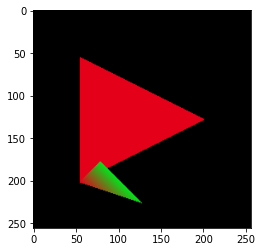

In [257]:
plt.imshow(pixel_uv.cpu().numpy())

In [77]:
visible_mask = output[-1]
visible_mask.shape

torch.Size([1, 256, 256, 1])

In [90]:
import cv2 as cv
from skimage import img_as_ubyte

# cv.imwrite('pixel_uv_two_tri.png', img_as_ubyte(pixel_uv.cpu().numpy()))

In [159]:
shading = output[-4] * output[3]
shading.shape

torch.Size([1, 3, 256, 256])

In [160]:
shading = torch.clamp(shading, 0)

In [161]:
shading = shading.squeeze()

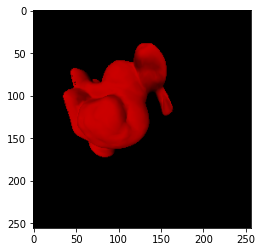

In [162]:
plt.imshow(shading.permute(1, 2, 0).cpu().numpy().astype(np.uint8))

In [167]:
cv.imwrite('output.png', shading.permute(1, 2, 0).cpu().numpy().astype(np.uint8)[..., [2, 1, 0]])

True

In [68]:
lighting_params

tensor([[ 0.7000,  0.7000,  0.7000,  0.1000,  0.1000,  0.1000,  0.0000,  0.0000,
         -1.0000]], device='cuda:0')

In [71]:
output[-1][0, :, 100, 100]

tensor([-0.4349,  0.1321,  0.8705], device='cuda:0')

In [34]:
mask= output[-3]
mask.shape

torch.Size([1, 256, 256, 1])

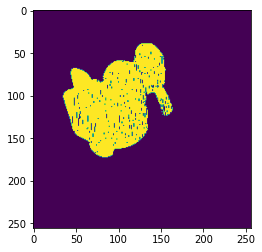

In [36]:
plt.imshow(mask.squeeze().cpu().numpy())